In [158]:
import pandas as pd
import numpy as np
import string
import re
import os
import time
import warnings
import ast

import matplotlib.pyplot as plt
import seaborn as sns

import dask
import dask.dataframe as dd
from dask import delayed

import folium 
from folium.plugins import MarkerCluster

import geopandas as gpd
from shapely.geometry import Point

from bokeh.plotting import figure, output_file, show
from bokeh.io import export_png
from bokeh.models import ColumnDataSource

from wordcloud import WordCloud
from textblob import TextBlob

import nltk
from nltk import ngrams
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer

from collections import Counter

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('vader_lexicon')
nltk.download('wordnet')

# Suppress warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/matthewaudley/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/matthewaudley/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/matthewaudley/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/matthewaudley/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/matthewaudley/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# Convert JSON to parquet files

# Paths to save the Parquet files
# parquet_dir = "../../data/processed/"

# # 1. 
# # Convert pandas DataFrames to Parquet
# data_tip = pd.read_json(f"../../data/raw/yelp_academic_dataset_tip.json", lines=True)
# data_tip.to_parquet(os.path.join(parquet_dir, "yelp_academic_dataset_tip.parquet"))

# # Convert Dask DataFrames to Parquet
# data_businesses = dd.read_json(f"../../data/raw/yelp_academic_dataset_business.json", lines=True)
# data_businesses.to_parquet(os.path.join(parquet_dir, "yelp_academic_dataset_business.parquet"))

# data_checkin = dd.read_json(f"../../data/raw/yelp_academic_dataset_checkin.json", lines=True)
# data_checkin.to_parquet(os.path.join(parquet_dir, "yelp_academic_dataset_checkin.parquet"))

# data_user = dd.read_json(f"../../data/raw/yelp_academic_dataset_user.json", lines=True)
# data_user.to_parquet(os.path.join(parquet_dir, "yelp_academic_dataset_user.parquet"))

# # Read the large JSON file with Dask in chunks and convert to Parquet
# data_review = dd.read_json(f"../../data/raw/yelp_academic_dataset_review.json", lines=True, blocksize="64MB")
# data_review.to_parquet(os.path.join(parquet_dir, "yelp_academic_dataset_review.parquet"))



# Read and save sample data for larger files
# data_user = dd.read_json('../../data/raw/yelp_academic_dataset_user.json', lines=True, blocksize=40000000)  # 1MB blocksize
# data_user_sample = data_user.head(5000)  # Adjust the number of rows to read
# data_user_sample.to_parquet(os.path.join(parquet_dir, "yelp_academic_dataset_review_user.parquet"))

# # Review Data
# data_review = dd.read_json(f"../../data/raw/yelp_academic_dataset_review.json", lines=True, blocksize=40000000)
# data_review = data_review.head(5000)
# data_review.to_parquet(os.path.join(parquet_dir, "yelp_academic_dataset_review_sample.parquet"))



In [145]:

# Load data and set indices
data_businesses = dd.read_parquet("../../data/processed/yelp_academic_dataset_business.parquet")
data_businesses = data_businesses.set_index('business_id')

data_checkin = dd.read_parquet("../../data/processed/yelp_academic_dataset_checkin.parquet")
data_checkin = data_checkin.set_index('business_id')

data_tip = dd.read_parquet("../../data/processed/yelp_academic_dataset_tip.parquet")

data_review_sample = dd.read_parquet("../../data/processed/yelp_academic_dataset_review_sample.parquet")
data_review_sample = data_review_sample.set_index('review_id')

data_user_sample = dd.read_parquet("../../data/processed/yelp_academic_dataset_user_sample.parquet")
data_user_sample = data_user_sample.set_index('user_id')


df_dict = {
    'bus_df': data_businesses,
    'checkin_df': data_checkin,
    'tip_df': data_tip,
    'review_df': data_review_sample,
    'user_df': data_user_sample
}


In [146]:

# Define the processing instructions
processes = {
    "bus_df": {
        "bool": ["is_open"],
        "dict": ["attributes", "hours"],
        "lists": ["categories"]
    },
    "checkin_df": {
        "date_time_list": ["date"]
    },
    "tip_df": {
        "date_time": ["date"],
        "string": ["text"]
    },
    "user_df": {
        "date_time": ["yelping_since"], #yelping since already shows in datetime...
        "lists": ["elite", "friends"]
    },
    "review_df": {
        "date_time": ["date"],
        "string": ["text"]
    }
}

for df_name, df in df_dict.items():
    
    instructions = processes[df_name]

    for dtype, cols in instructions.items():
        if dtype == "bool":
            for col in cols:
                df[col] = df[col].astype(bool)
        
        elif dtype == "date_time":
            for col in cols:
                df[col] = dd.to_datetime(df[col], errors='coerce')
                
        elif dtype == "string":
            for col in cols:
                df[col] = df[col].str.lower()
        
        elif dtype == "date_time_list":
            # continue
            for col in cols:
                df[col] = df[col].str.split(', ').map(
                    lambda x: pd.to_datetime(x, format="%Y-%m-%d %H:%M:%S", errors='coerce') 
                    if isinstance(x, list) else [],
                    meta=('x', 'object')
                )
        elif dtype == "dict":
            # continue
            for col in cols:
                df[col] = df[col].map(
                    lambda x: ast.literal_eval(x) if pd.notna(x) and isinstance(x, str) else {}, 
                    meta=('x', 'object')
                )
        
        elif dtype == "lists":
            # continue
            for col in cols:
                df[col] = df[col].map(
                    lambda x: x.split(', ') if pd.notna(x) and isinstance(x, str) else [], 
                    meta=('x', 'object')
                )
        
        

    # df_dict[df_name] = df

# If you need to compute the results, you can do so here:
# for df_name in df_dict:
#     df_dict[df_name] = df_dict[df_name].compute()

In [147]:
# Save dataset

# # Assuming df_dict contains Dask DataFrames
# for name, ddf in df_dict.items():
#     ddf.to_parquet(f'../../data/processed/{name}.parquet')  # or engine='fastparquet'


In [148]:
transformations = {
    "bus_df": {
        "log1p": ['review_count']
    },
    "review_df" : {
        "log1p" : ['stars', 'useful', 'funny', 'cool']
    },
    "user_df": {
        "log1p": ['review_count', 'useful', 'funny', 'cool', 'fans'] + [col for col in df_dict['user_df'].compute().columns if 'compliment' in col]   
    }
}

In [6]:
# data_checkin.compute().describe() #taking too long...

for df_name, df in df_dict.items():
    if df_name != "checkin_df":
        print(df_name)
        display(df.compute().describe())
        

bus_df


latitude      longitude          stars   review_count
count  150346.000000  150346.000000  150346.000000  150346.000000
mean       36.671150     -89.357339       3.596724      44.866561
std         5.872759      14.918502       0.974421     121.120136
min        27.555127    -120.095137       1.000000       5.000000
25%        32.187293     -90.357810       3.000000       8.000000
50%        38.777413     -86.121179       3.500000      15.000000
75%        39.954036     -75.421542       4.500000      37.000000
max        53.679197     -73.200457       5.000000    7568.000000

tip_df


date  compliment_count
count                         908915     908915.000000
mean   2015-06-14 10:13:53.302817280          0.012525
min              2009-04-16 13:11:49          0.000000
25%       2013-01-26 01:18:02.500000          0.000000
50%              2015-03-15 01:10:25          0.000000
75%       2017-08-02 06:19:55.500000          0.000000
max              2022-01-19 20:38:55          6.000000
std                              NaN          0.120763

review_df


stars      useful        funny         cool  \
count  5000.000000  5000.00000  5000.000000  5000.000000   
mean      3.838600     0.86880     0.252400     0.340000   
min       1.000000     0.00000     0.000000     0.000000   
25%       3.000000     0.00000     0.000000     0.000000   
50%       4.000000     0.00000     0.000000     0.000000   
75%       5.000000     1.00000     0.000000     0.000000   
max       5.000000    34.00000    19.000000    13.000000   
std       1.357983     1.71947     0.904244     0.968601   

                                date  
count                           5000  
mean   2015-04-13 15:23:19.728400128  
min              2005-03-12 03:47:06  
25%              2013-10-25 00:11:22  
50%       2015-09-23 23:04:05.500000  
75%              2017-03-15 19:22:29  
max              2018-10-04 18:10:01  
std                              NaN

user_df


review_count                  yelping_since         useful  \
count   4211.000000                           4211    4211.000000   
mean     341.816671  2009-05-08 13:15:50.810496512    1275.876276   
min        1.000000            2005-01-03 18:01:35       0.000000   
25%       42.000000            2008-03-15 06:30:46      60.000000   
50%      145.000000            2009-06-18 21:29:13     244.000000   
75%      399.000000     2010-08-03 00:38:08.500000     868.000000   
max     9941.000000            2013-07-30 17:49:45  124311.000000   
std      582.808313                            NaN    4488.603479   

              funny           cool         fans  average_stars  \
count   4211.000000    4211.000000  4211.000000    4211.000000   
mean     684.314890     883.991926    44.503681       3.830869   
min        0.000000       0.000000     0.000000       1.000000   
25%       15.000000      19.000000     2.000000       3.600000   
50%       79.000000     101.000000    10.000000       3.830000   
75%      344.500000     436.500000    36.000000       4.060000   
max    91842.000000  113069.000000  3138.000000       5.000000   
std     2908.094407    3755.493255   142.928365       0.431512   

       compliment_hot  compliment_more  compliment_profile  compliment_cute  \
count     4211.000000      4211.000000         4211.000000      4211.000000   
mean        93.666588        11.848730            9.772738         8.834244   
min          0.000000         0.000000            0.000000         0.000000   
25%          0.000000         0.000000            0.000000         0.000000   
50%          5.000000         2.000000            1.000000         0.000000   
75%         33.000000         7.000000            3.000000         3.000000   
max      12391.000000      3575.000000         5662.000000      1744.000000   
std        433.074690        69.657934           98.640596        51.187551   

       compliment_list  compliment_note  compliment_plain  compliment_cool  \
count      4211.000000      4211.000000       4211.000000      4211.000000   
mean          5.336737        56.616481        144.450724       128.450962   
min           0.000000         0.000000          0.000000         0.000000   
25%           0.000000         1.000000          1.000000         1.000000   
50%           0.000000         7.000000          9.000000        10.000000   
75%           2.000000        28.000000         45.000000        51.000000   
max        2261.000000      4901.000000      16674.000000     13262.000000   
std          44.008681       218.024305        714.616047       562.896788   

       compliment_funny  compliment_writer  compliment_photos  
count       4211.000000        4211.000000        4211.000000  
mean         128.450962          48.126098          37.050344  
min            0.000000           0.000000           0.000000  
25%            1.000000           1.000000           0.000000  
50%           10.000000           4.000000           1.000000  
75%           51.000000          22.500000           6.000000  
max        13262.000000        6574.000000       14045.000000  
std          562.896788         223.647099         342.897864


Processing bus_df:


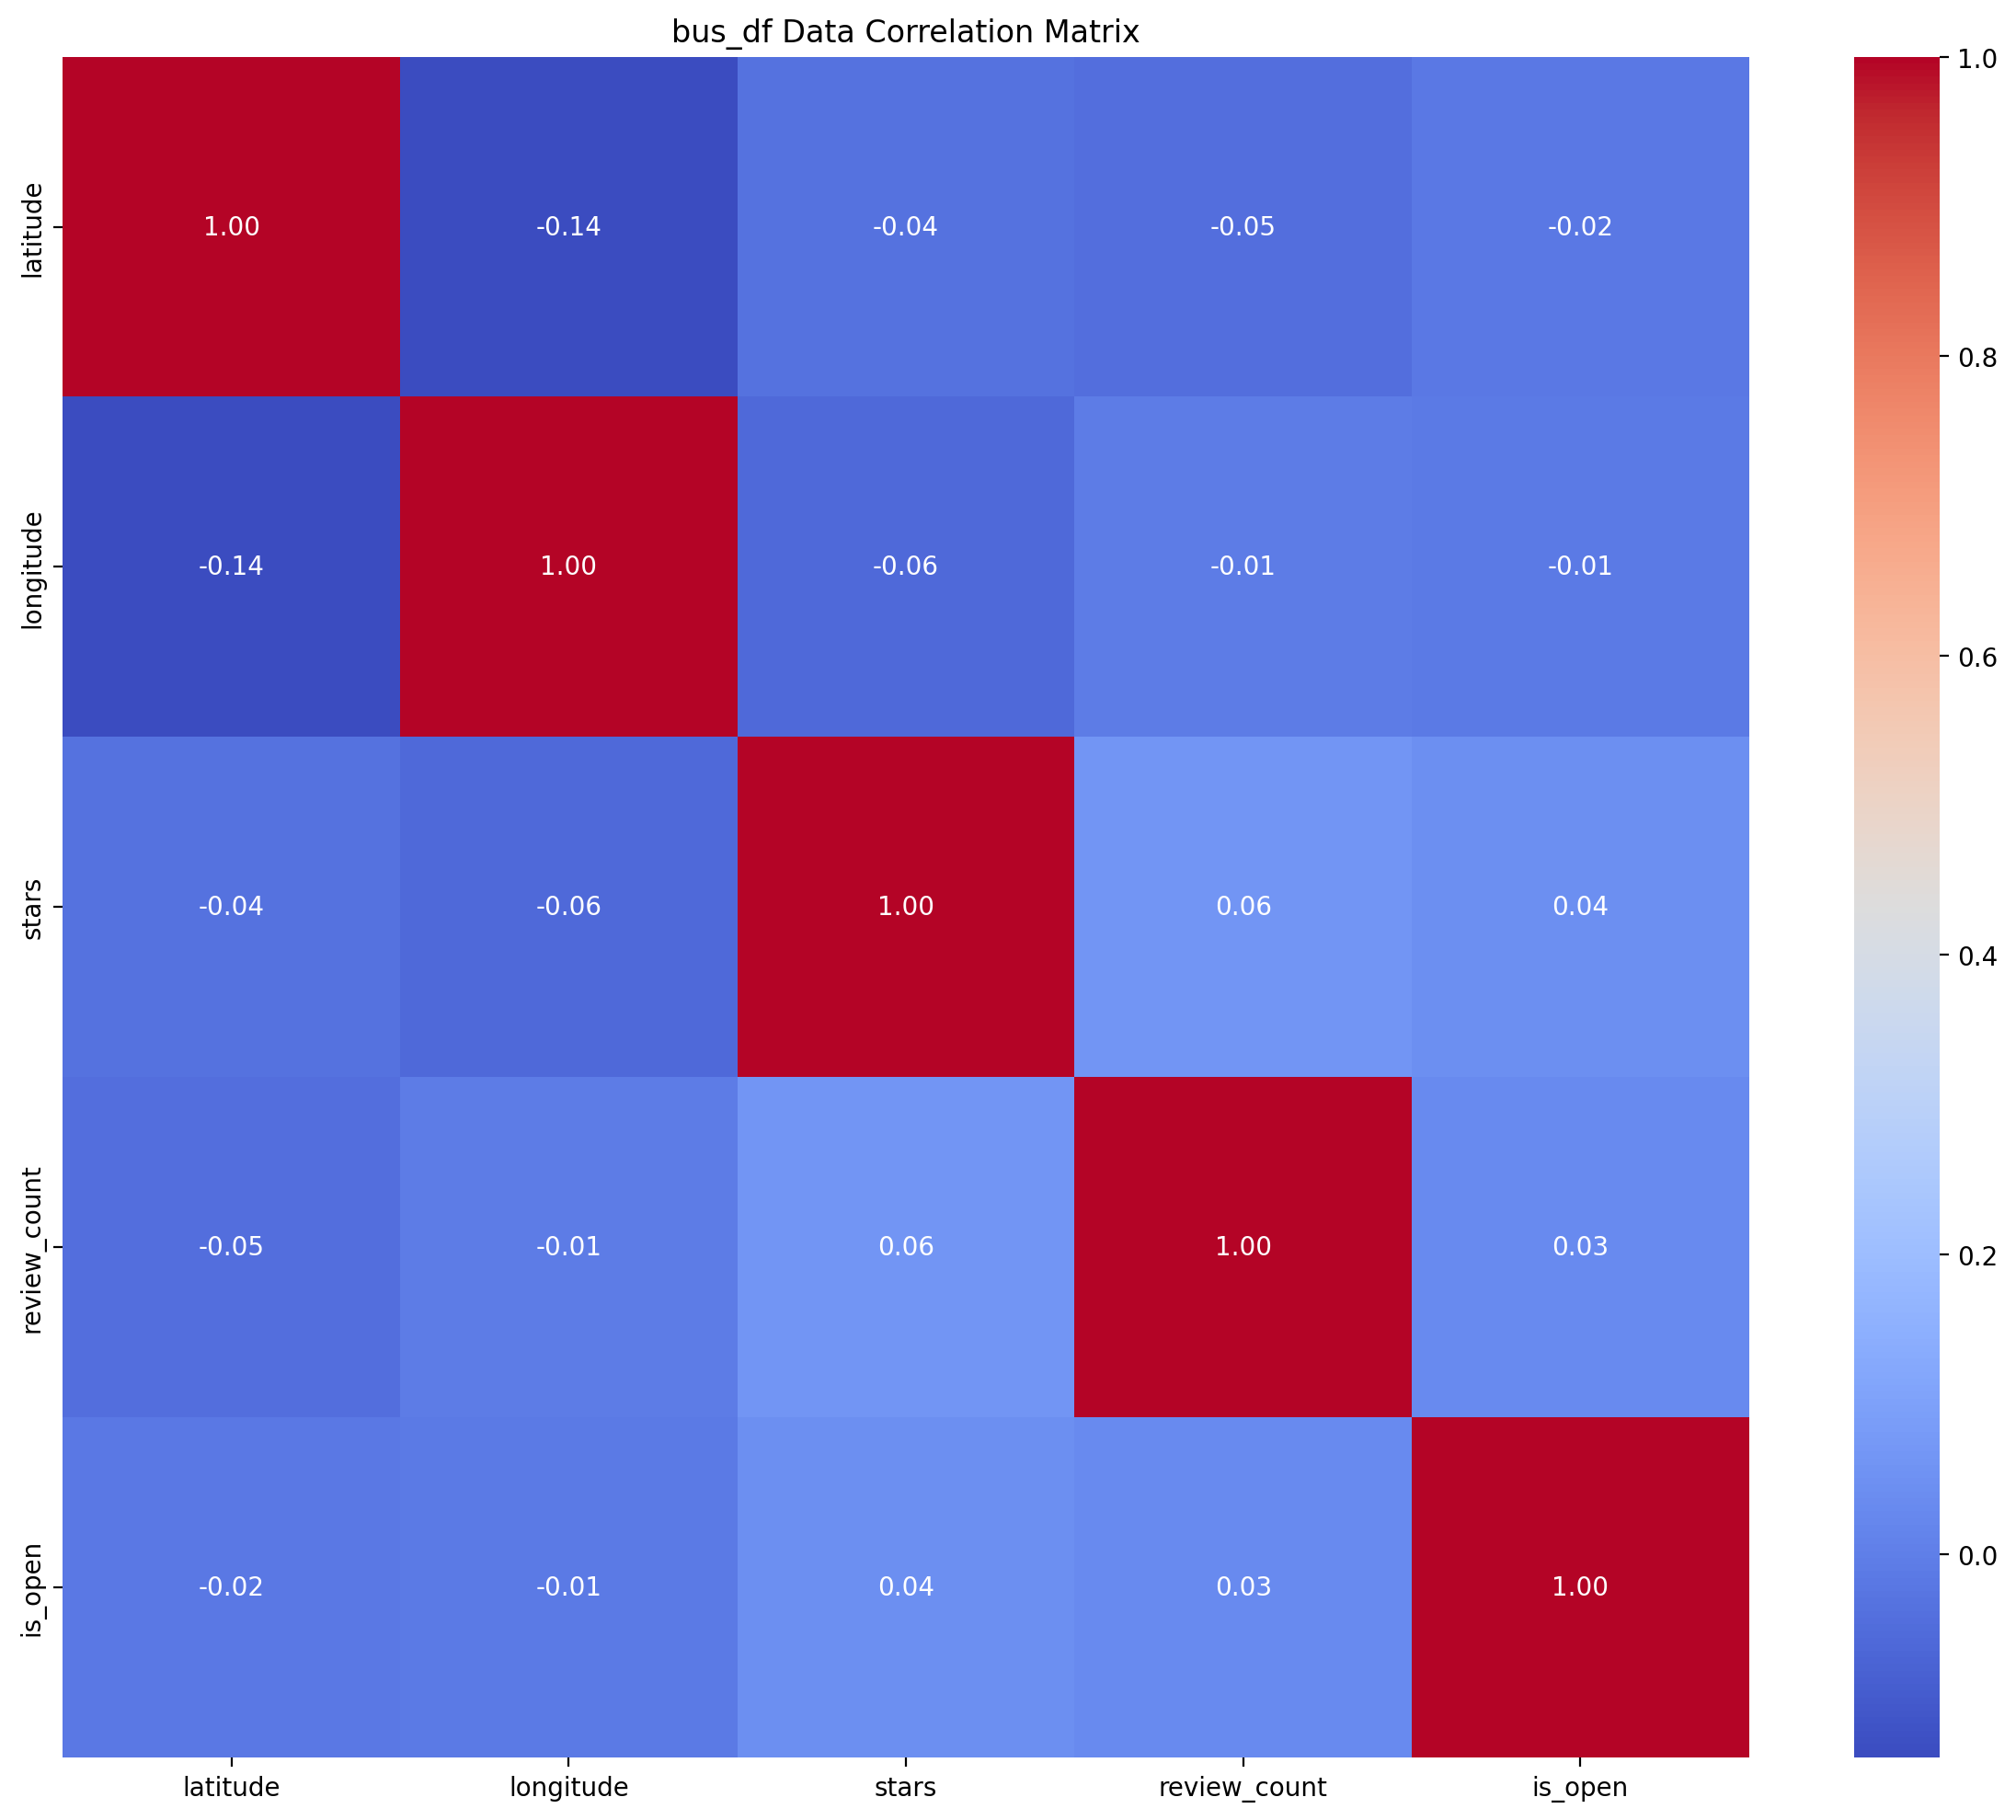

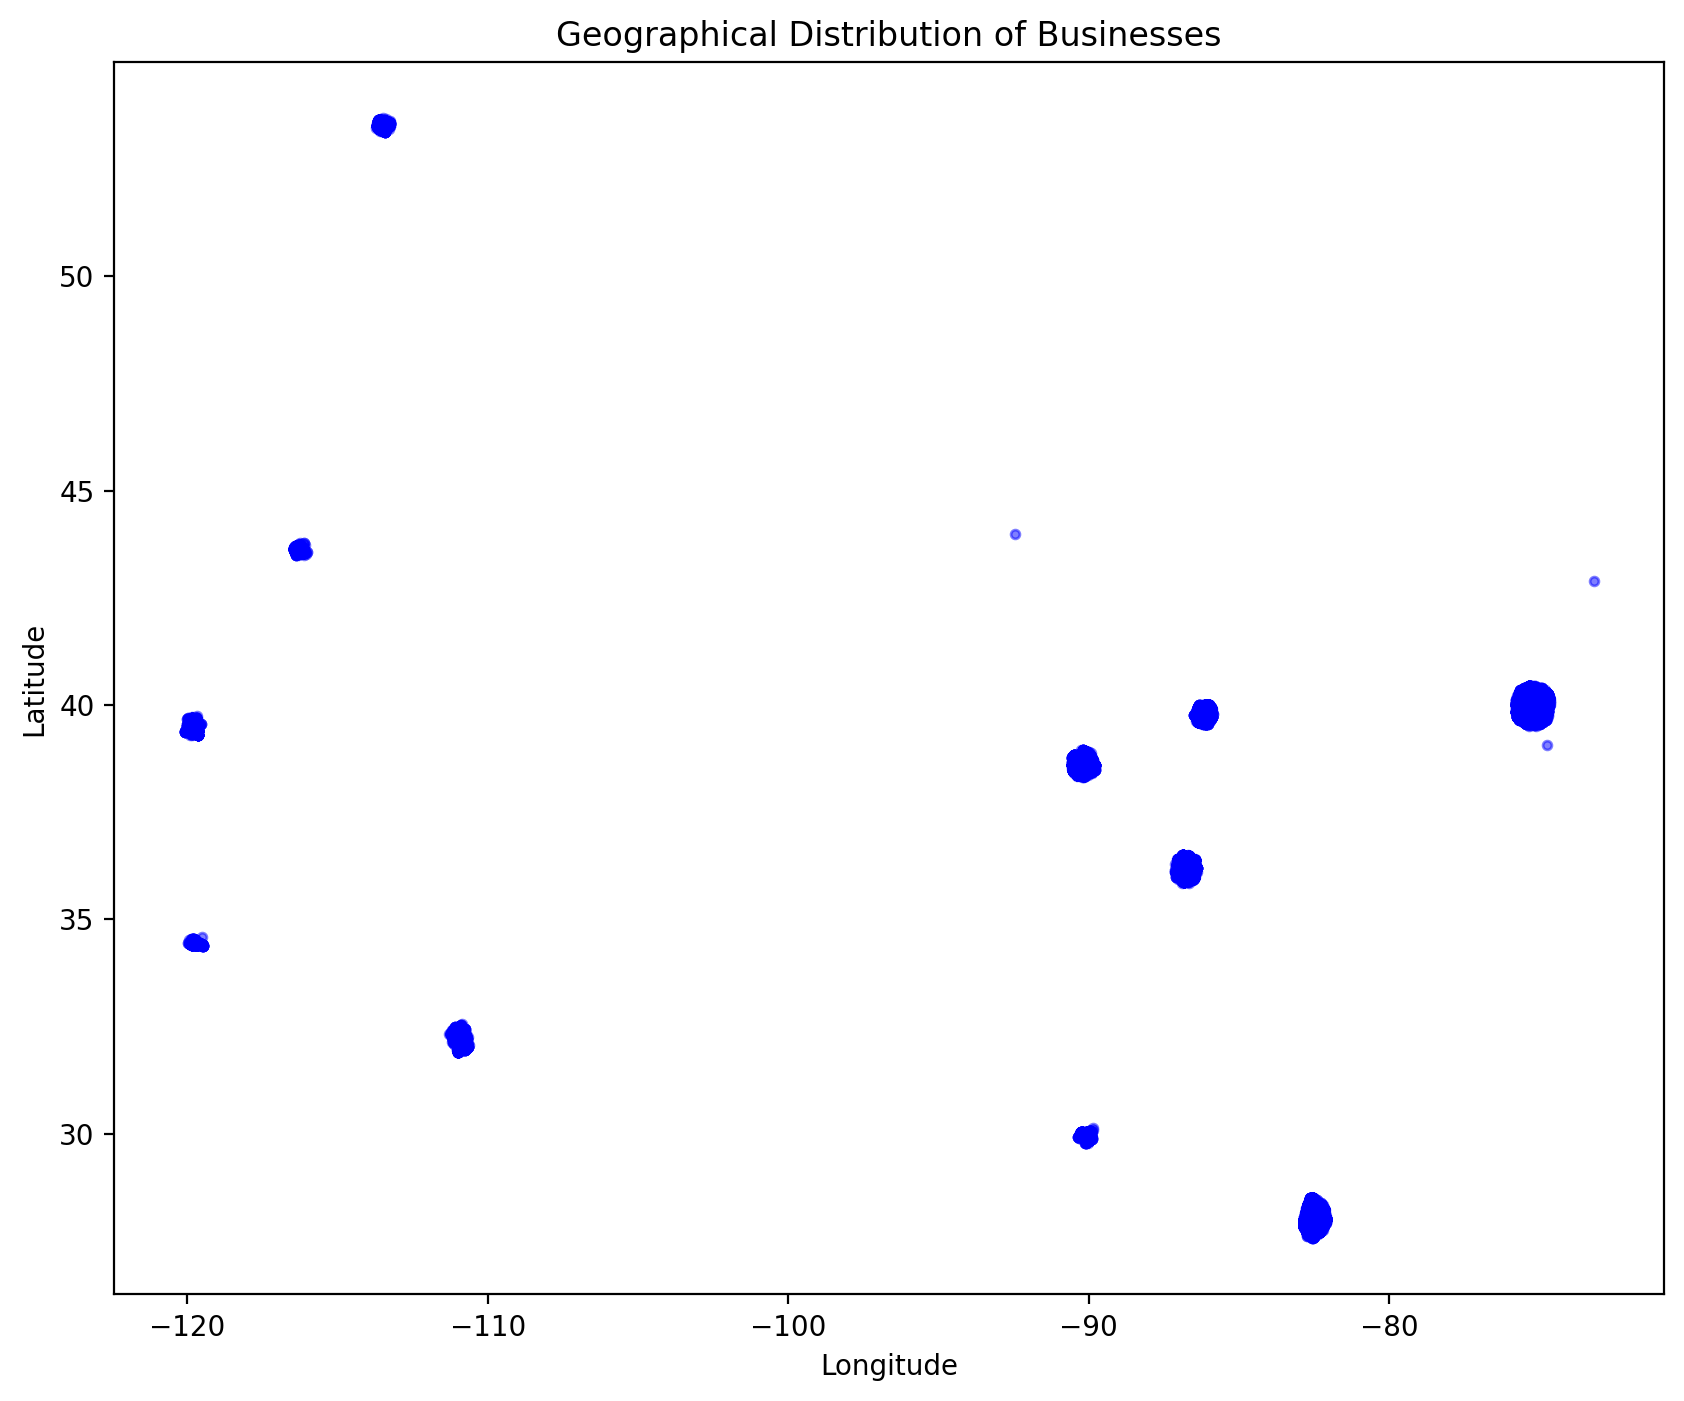

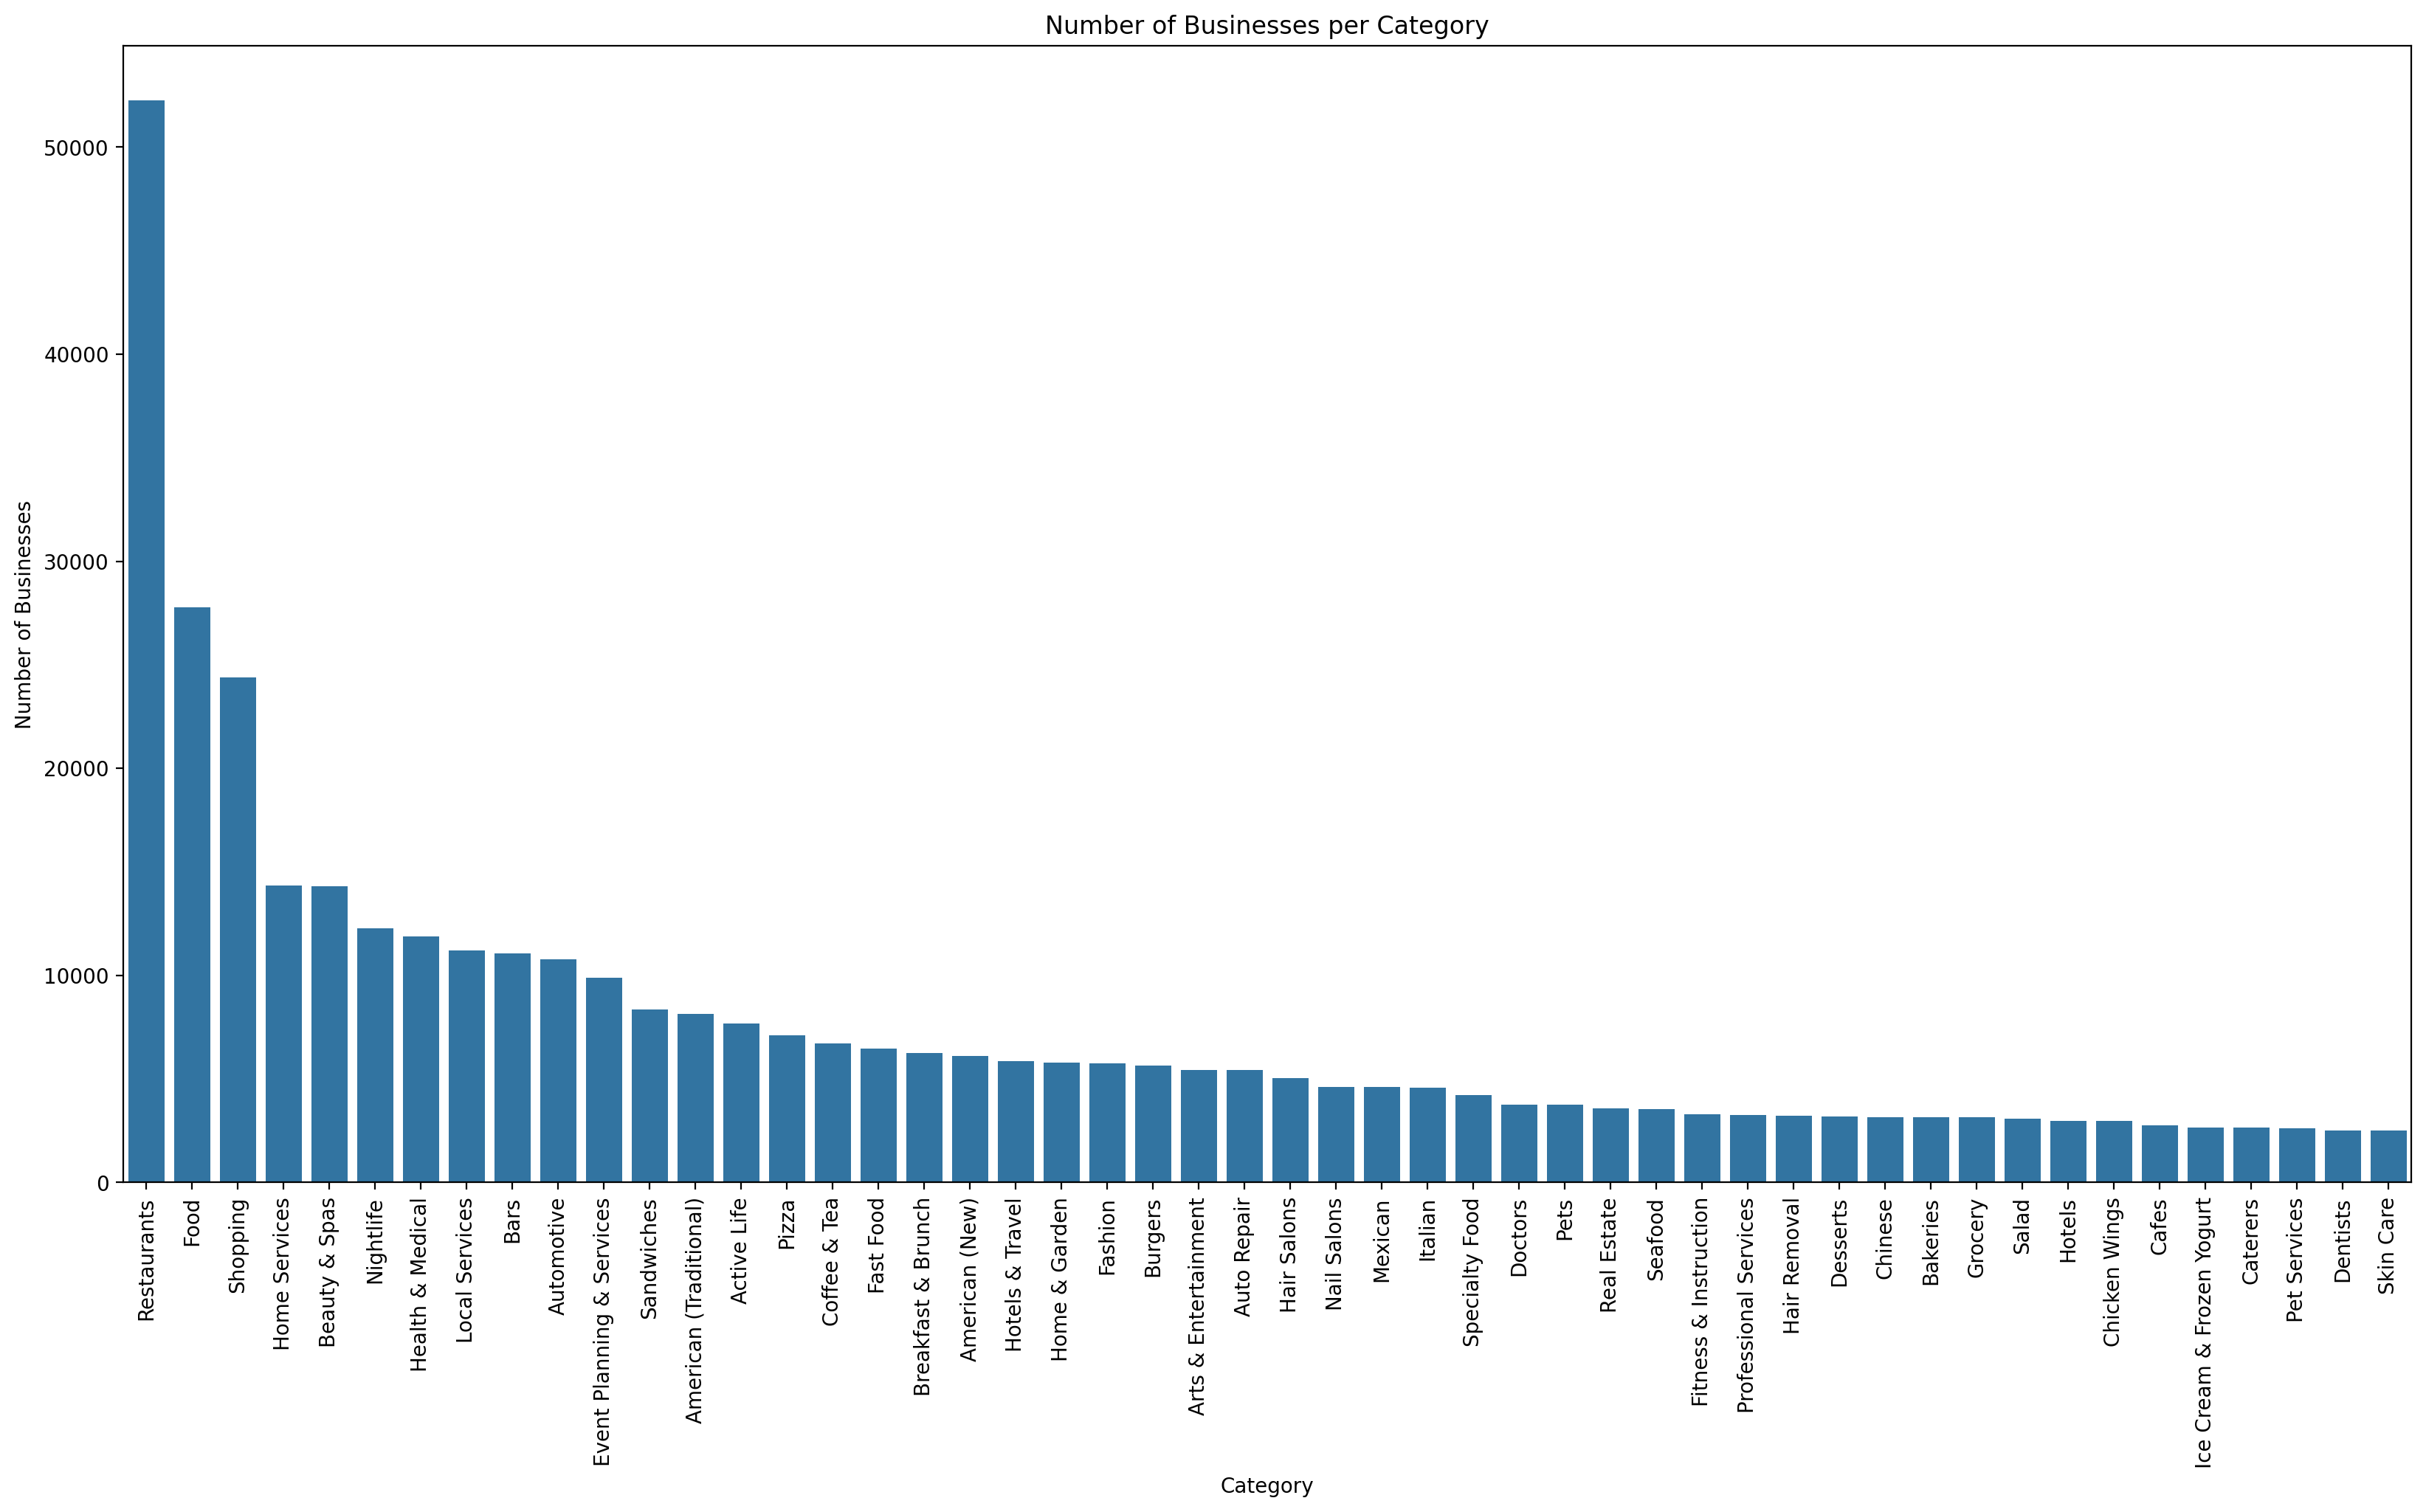

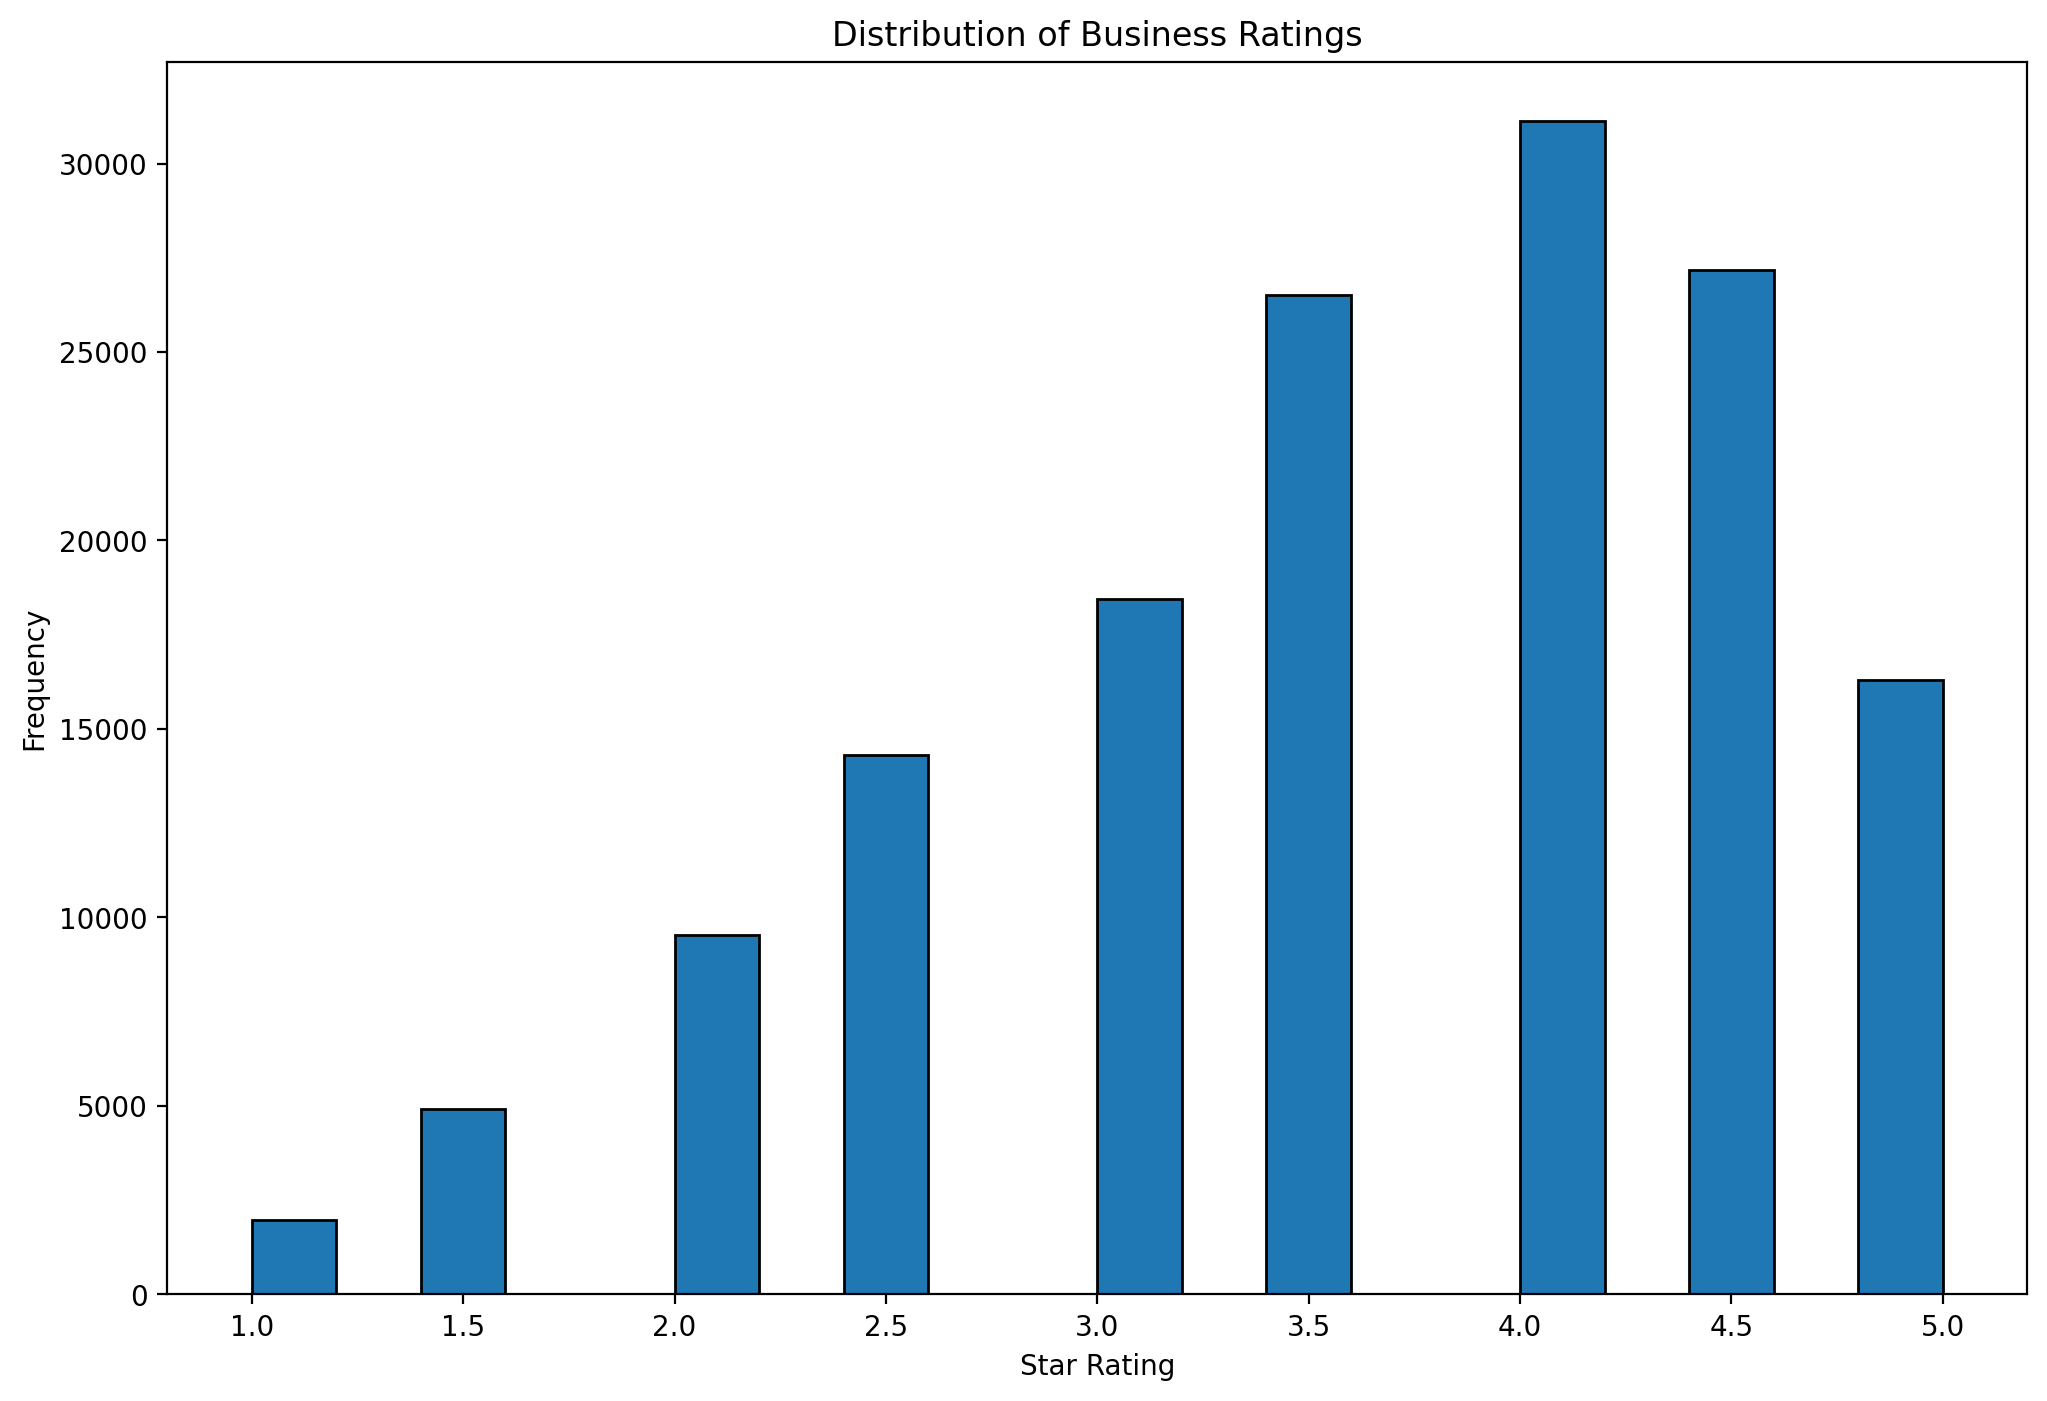

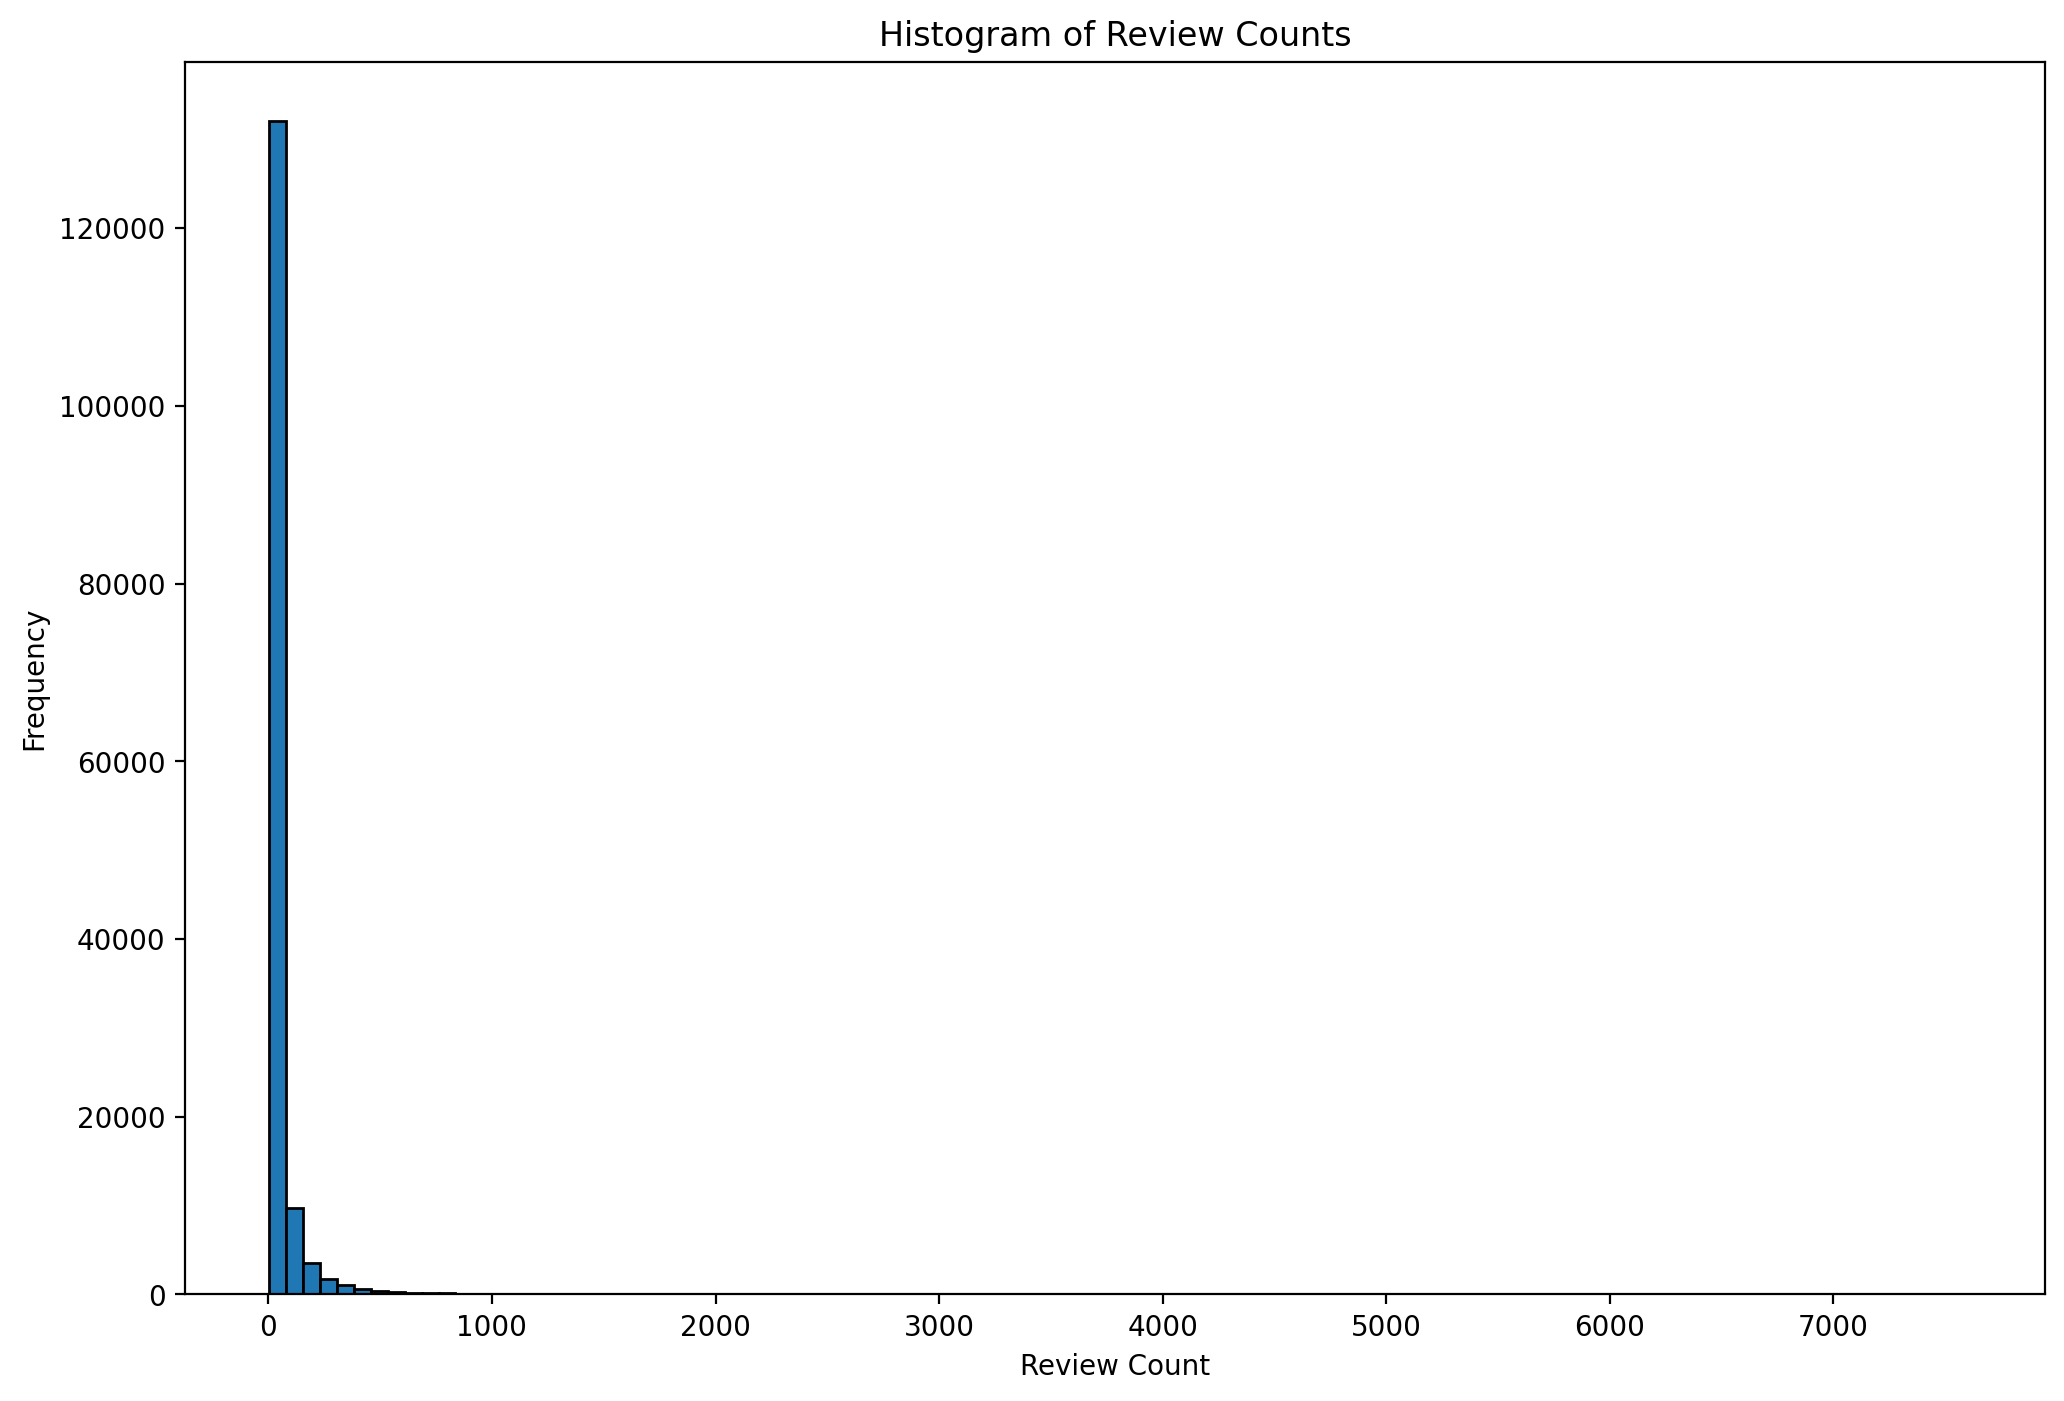

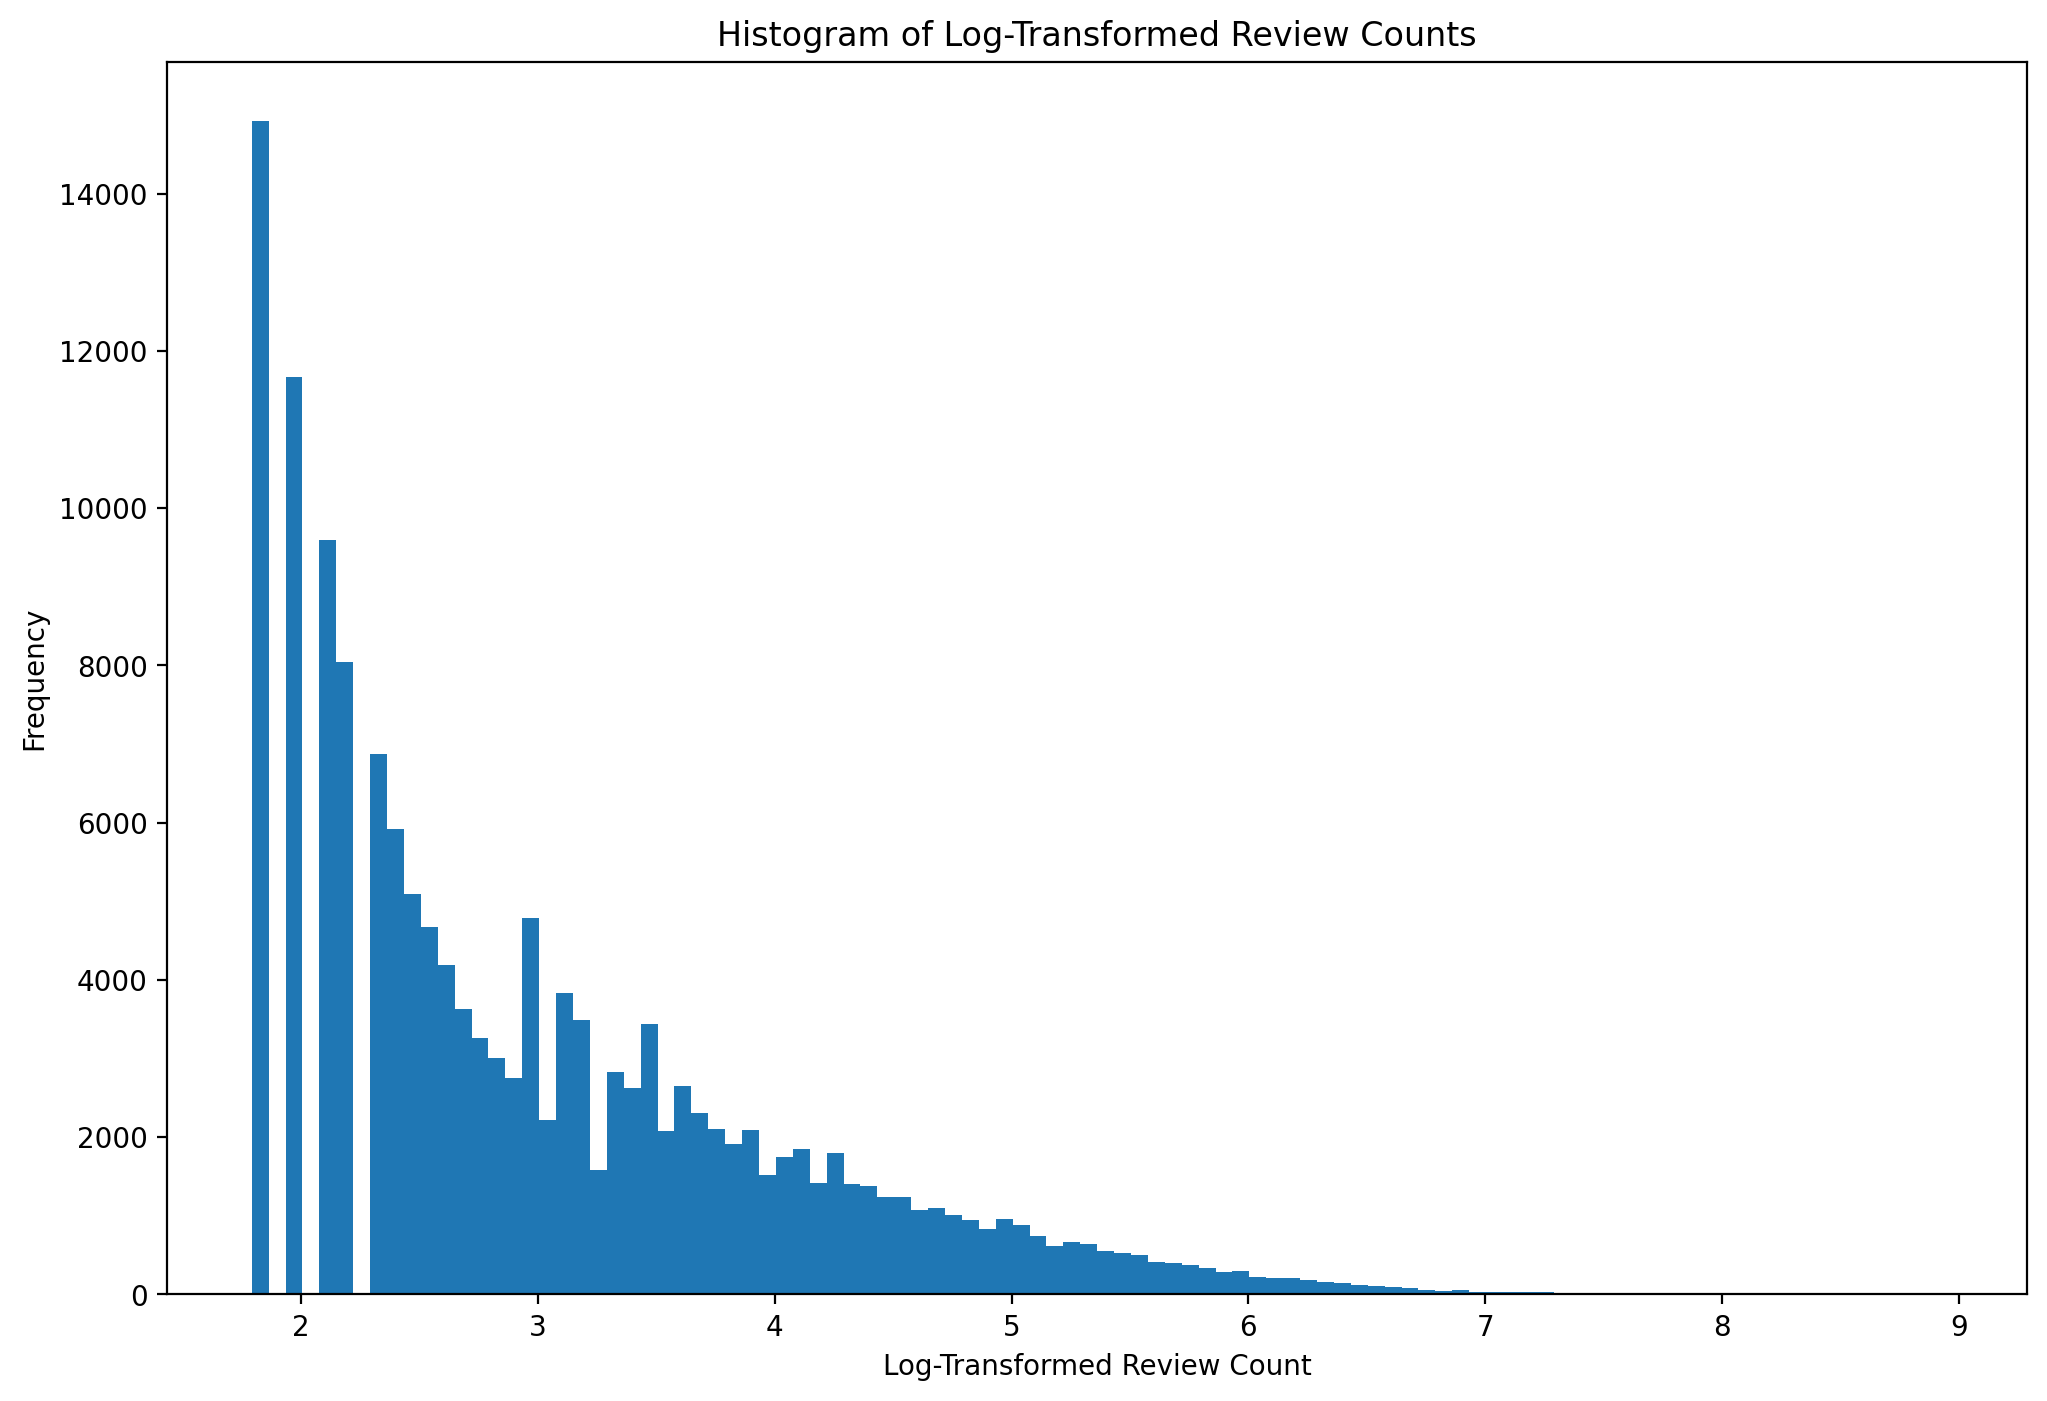

Finished processing bus_df

Processing tip_df:


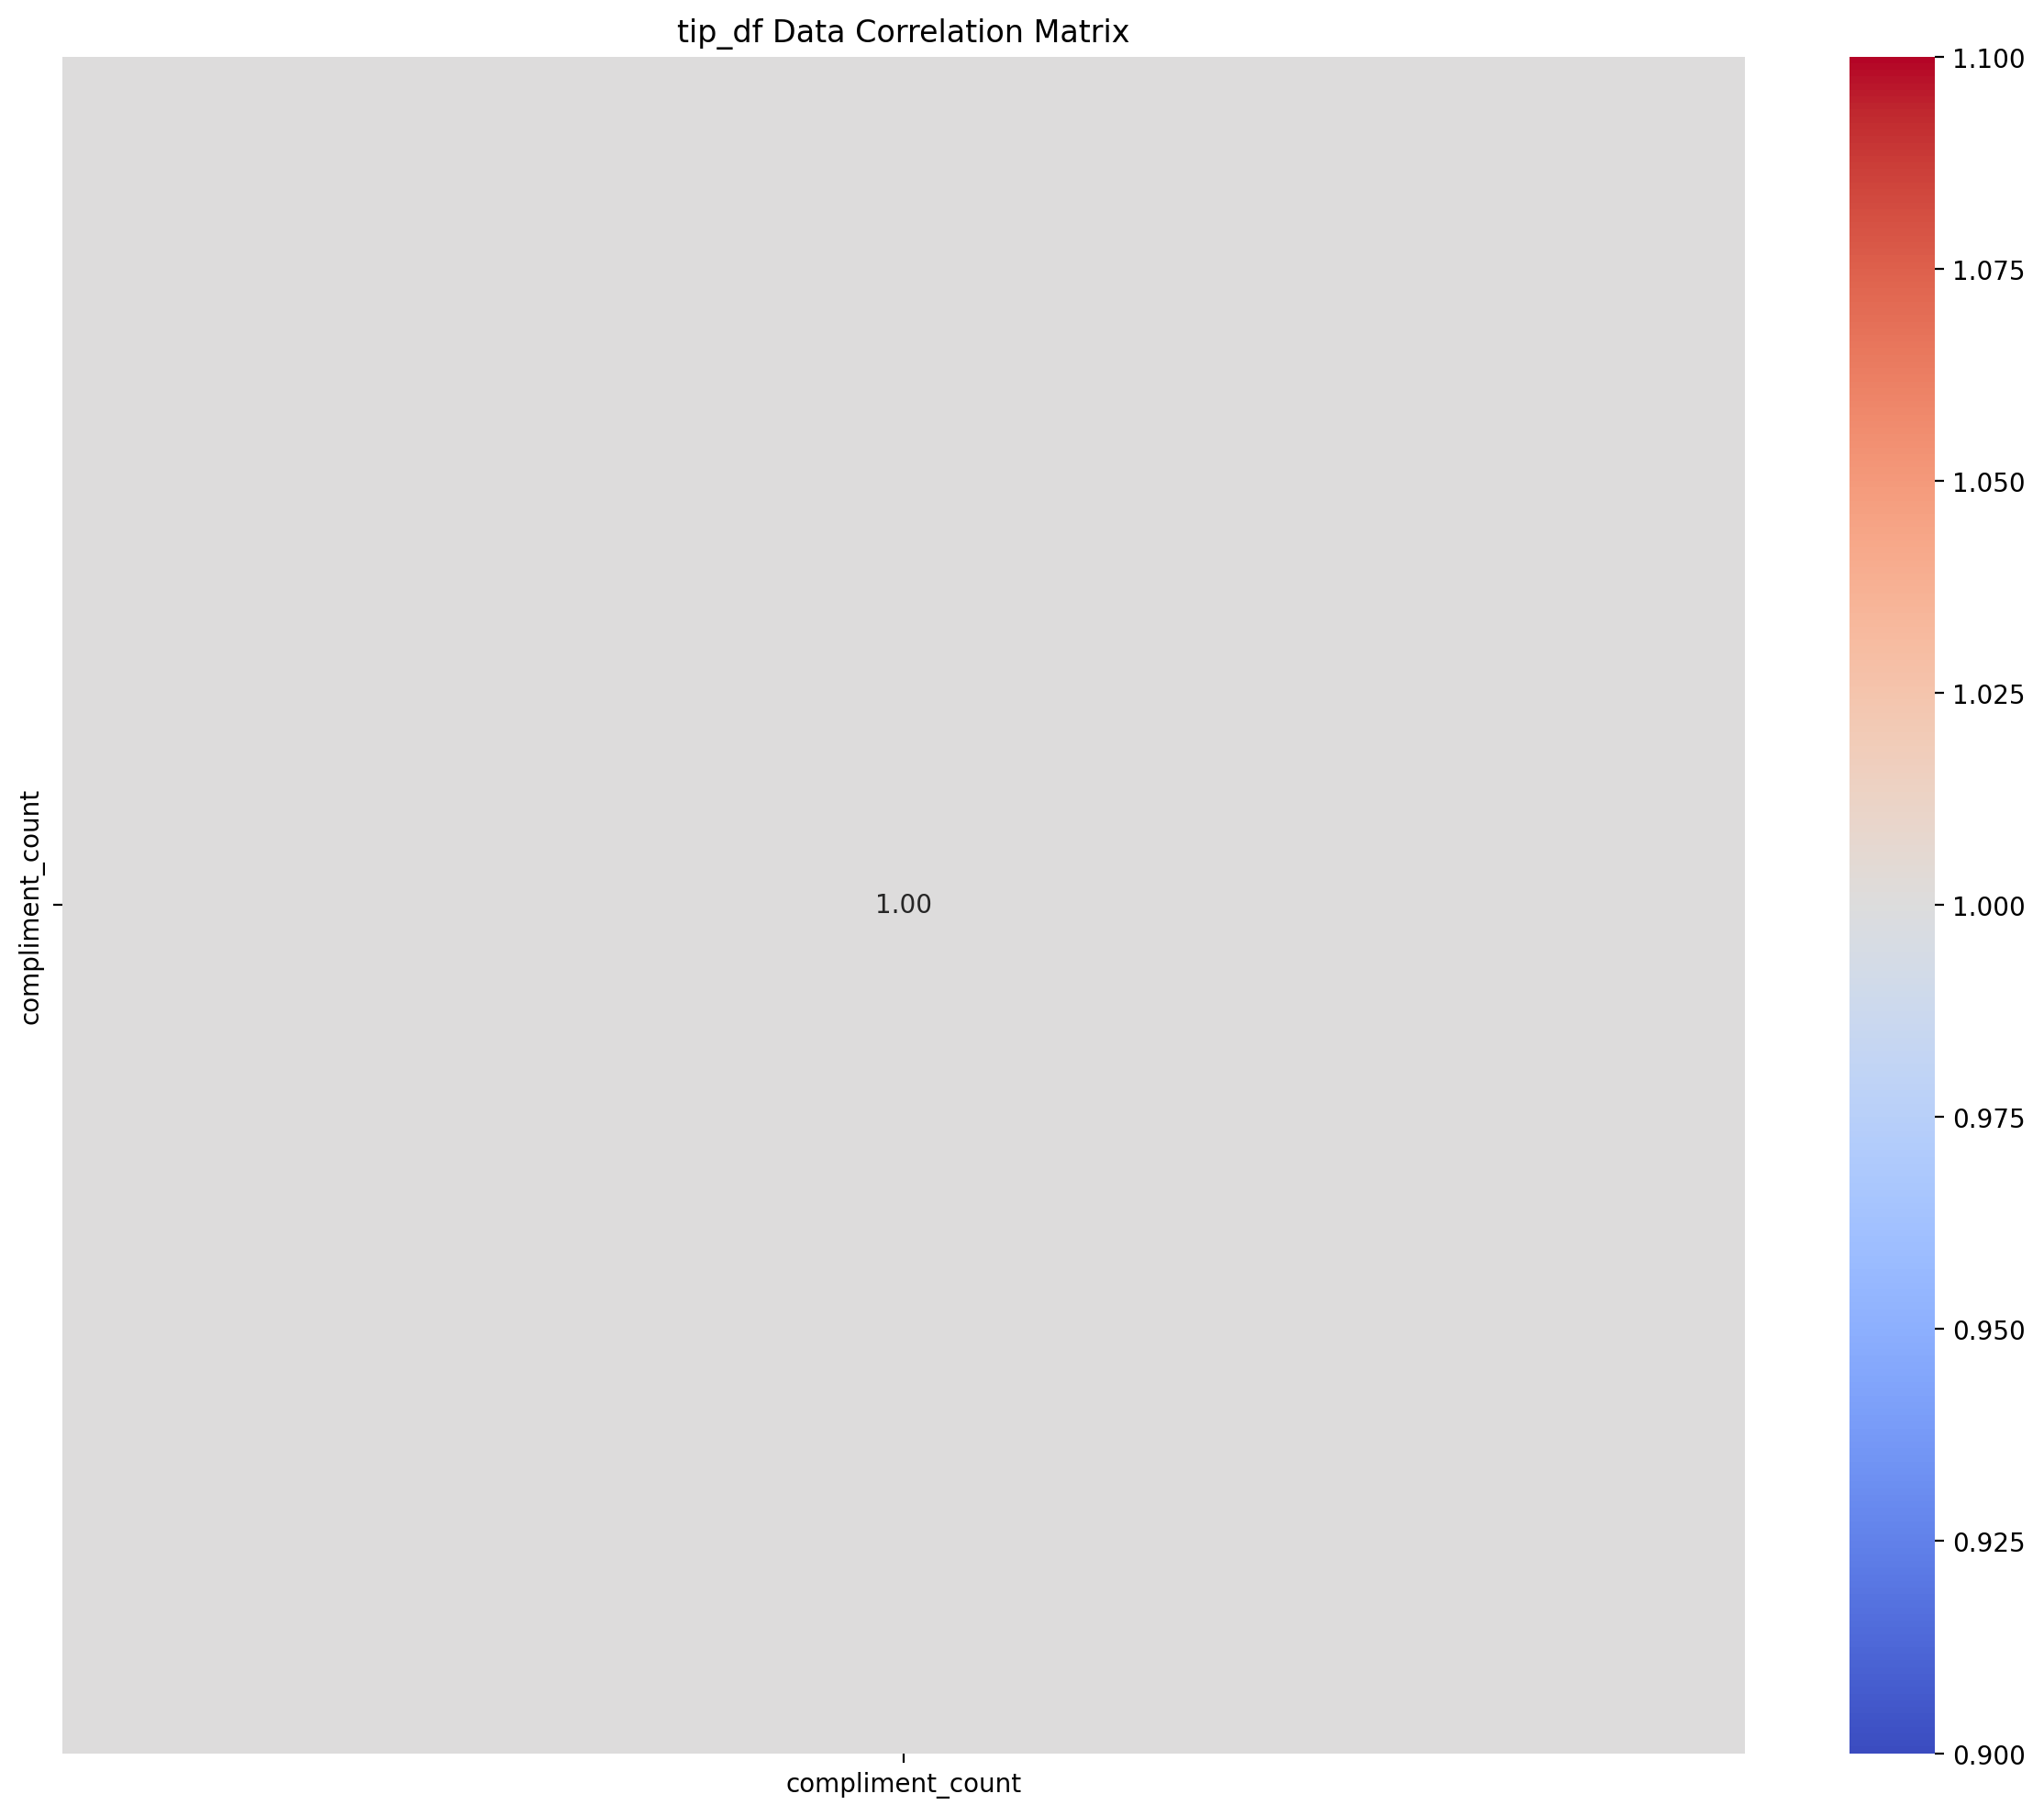

Finished processing tip_df

Processing review_df:


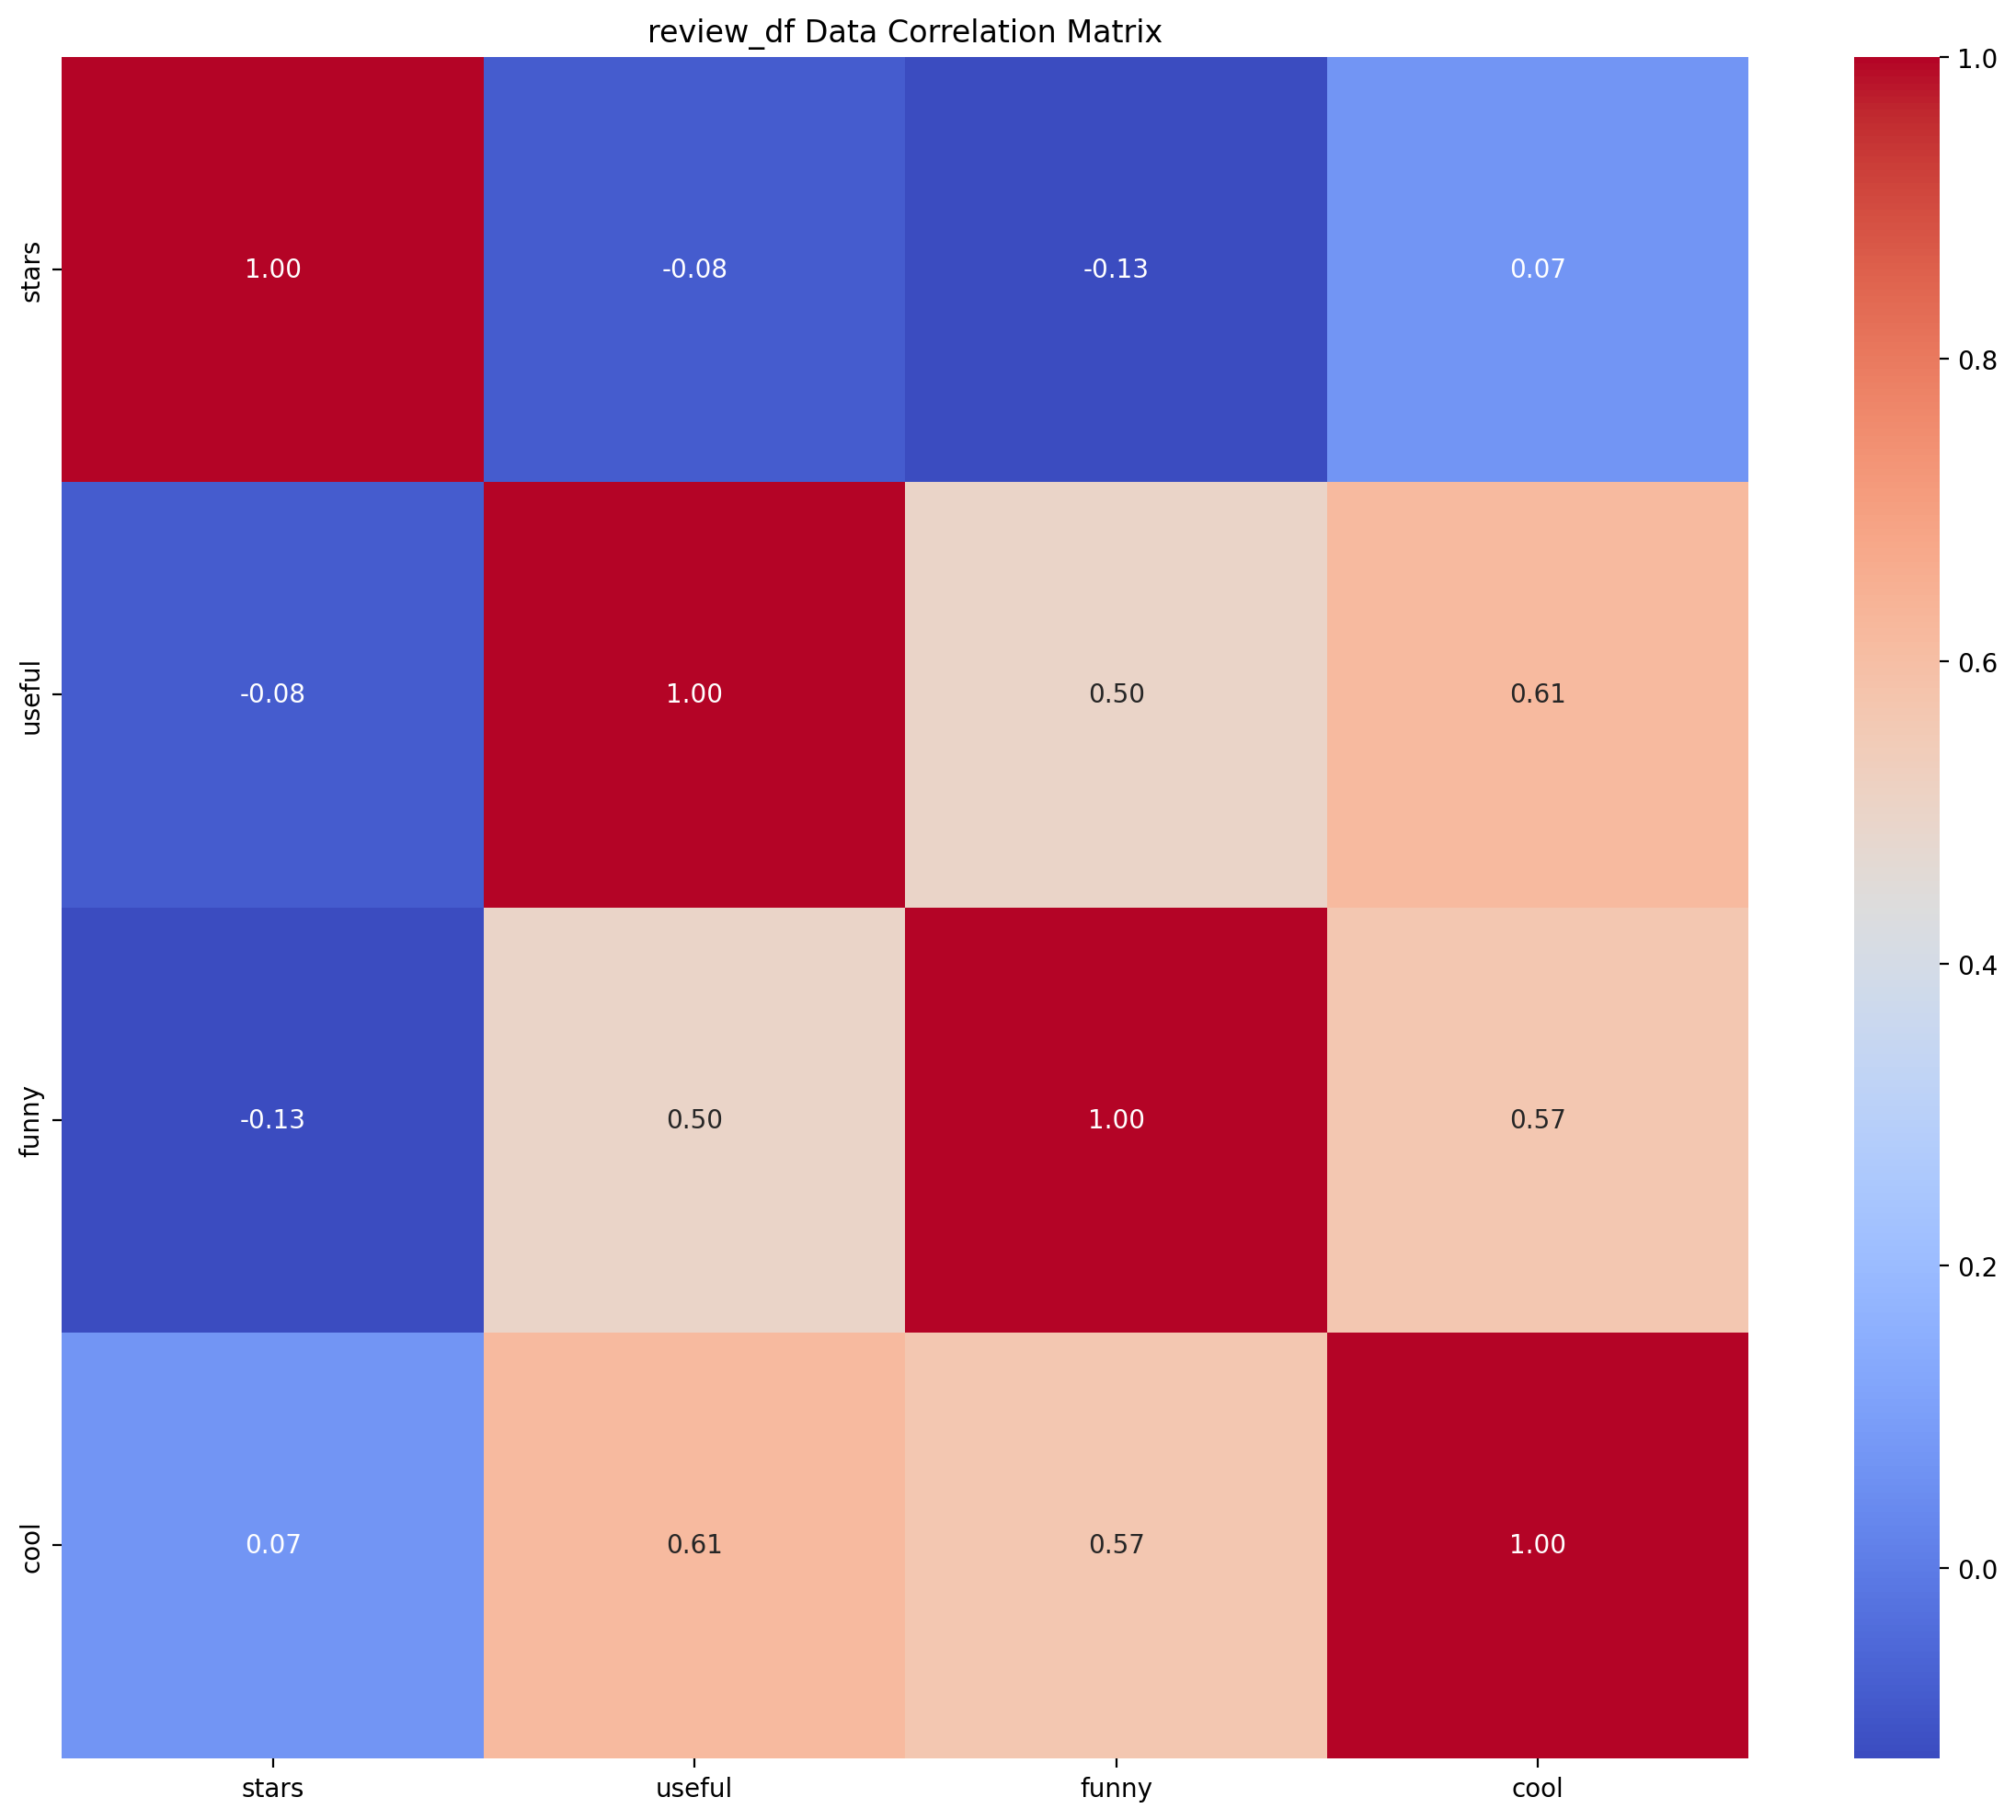

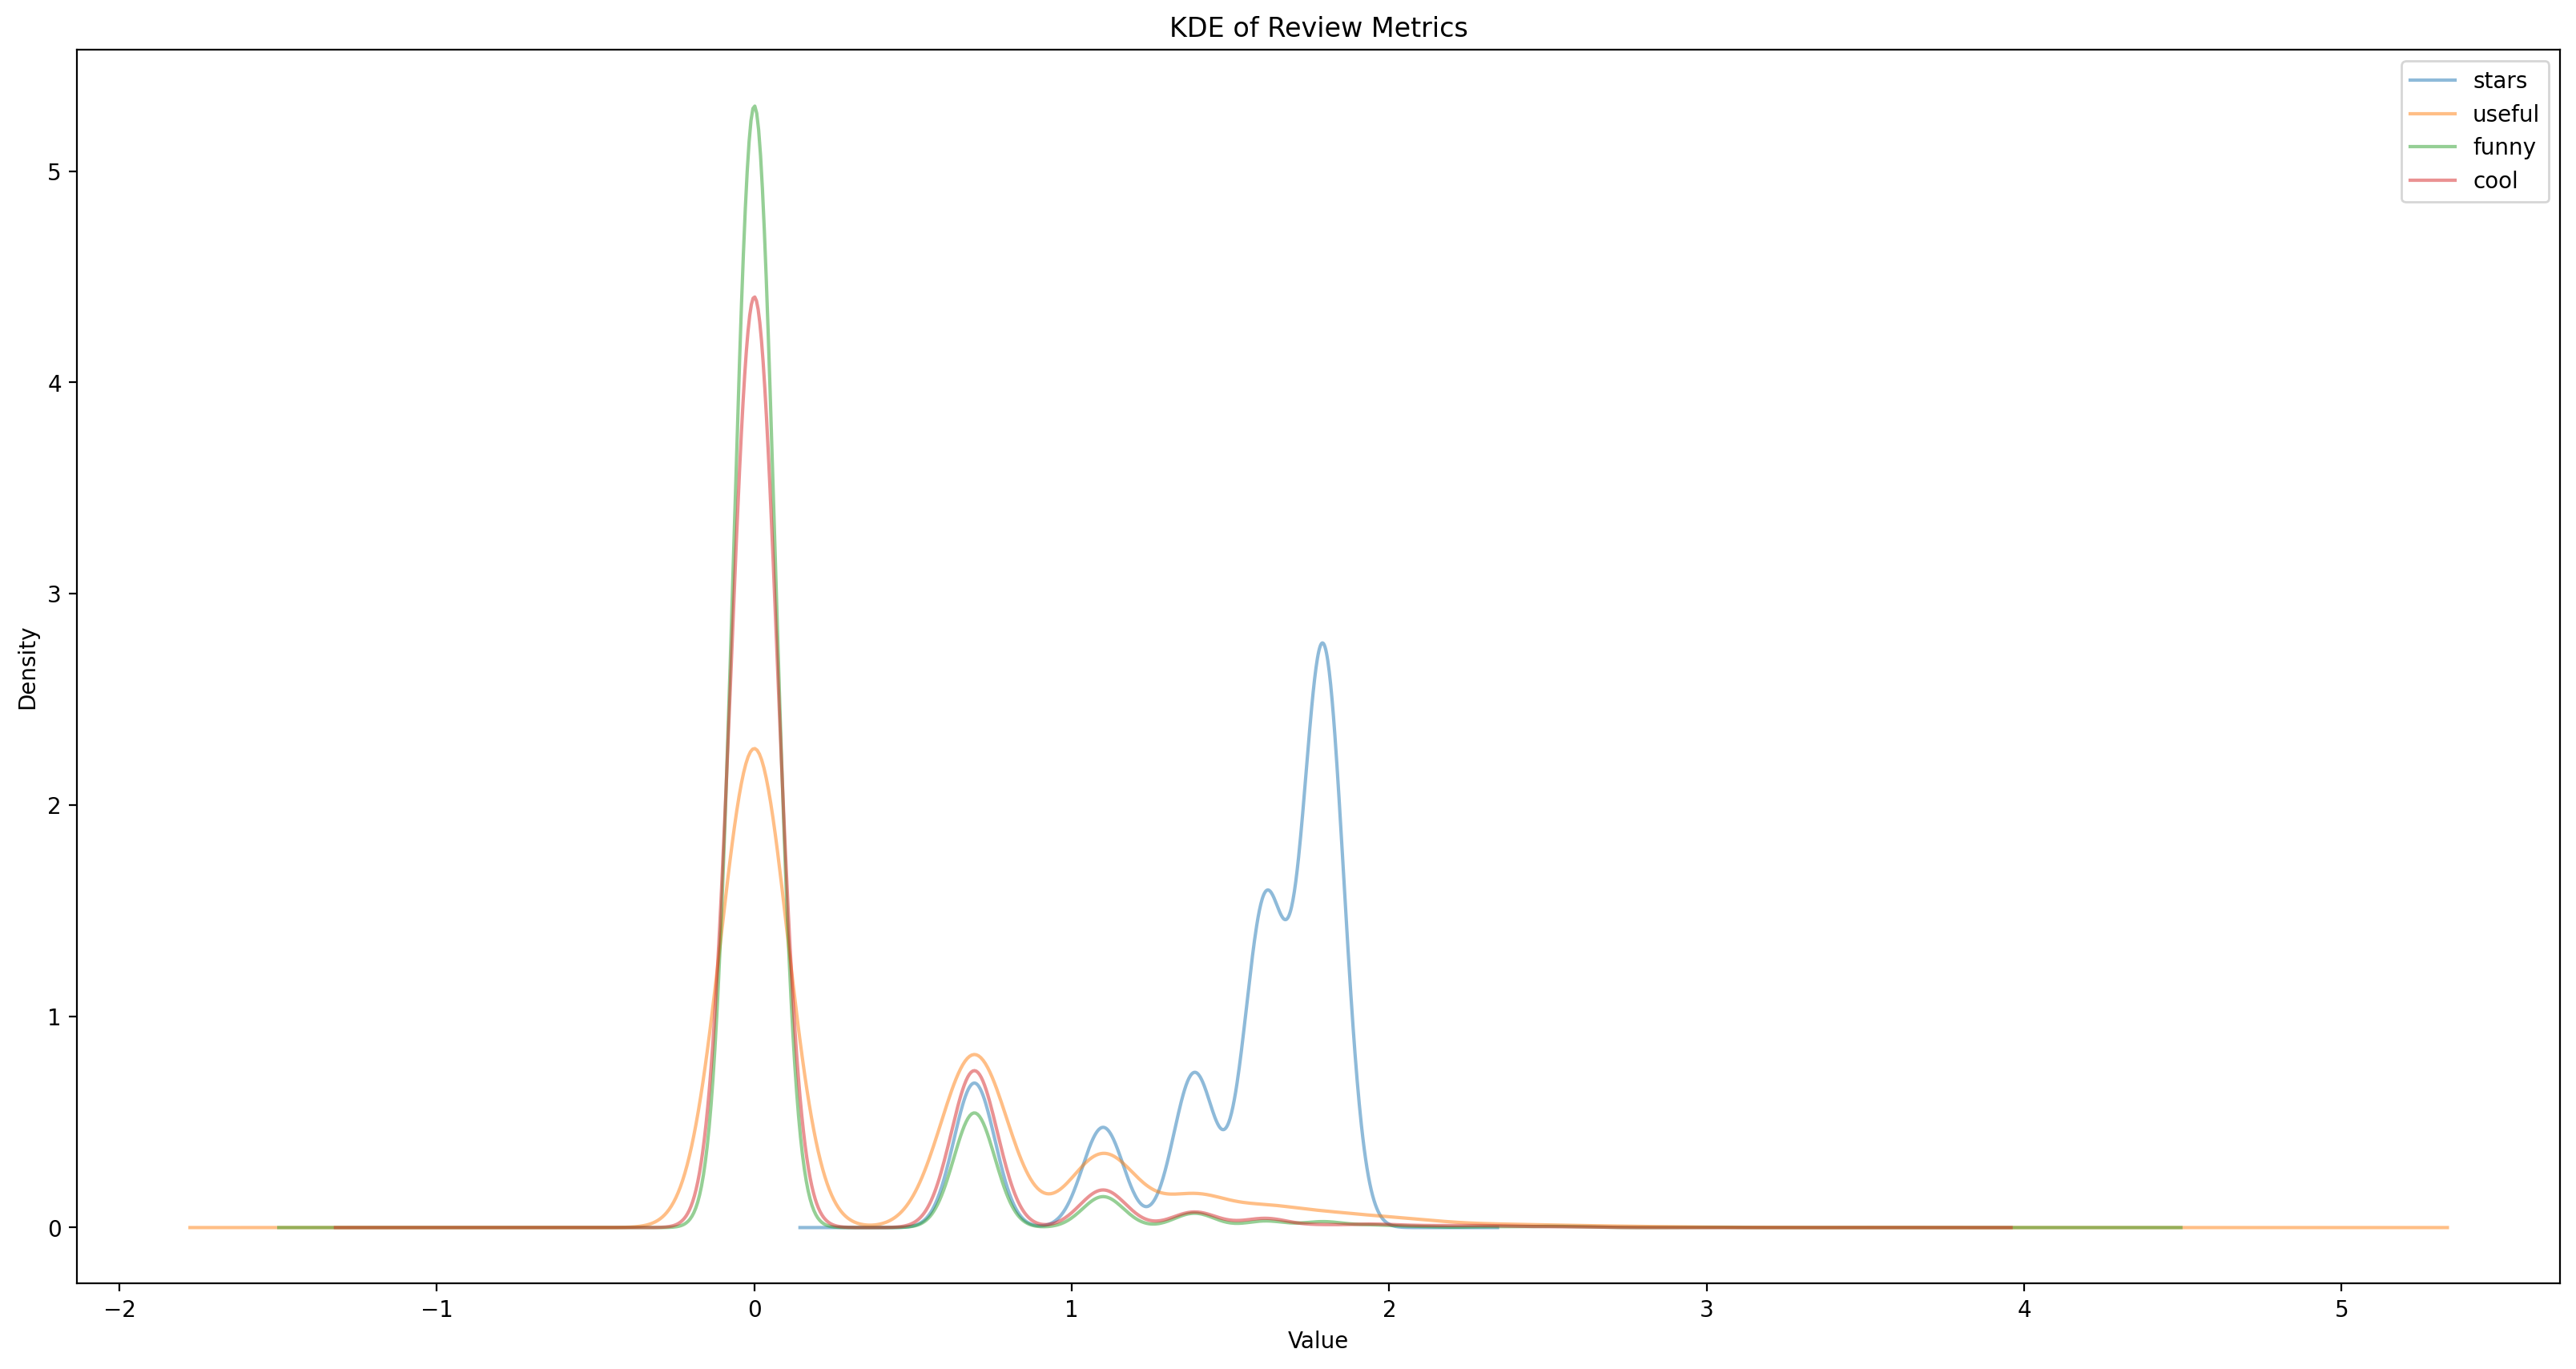

Finished processing review_df

Processing user_df:


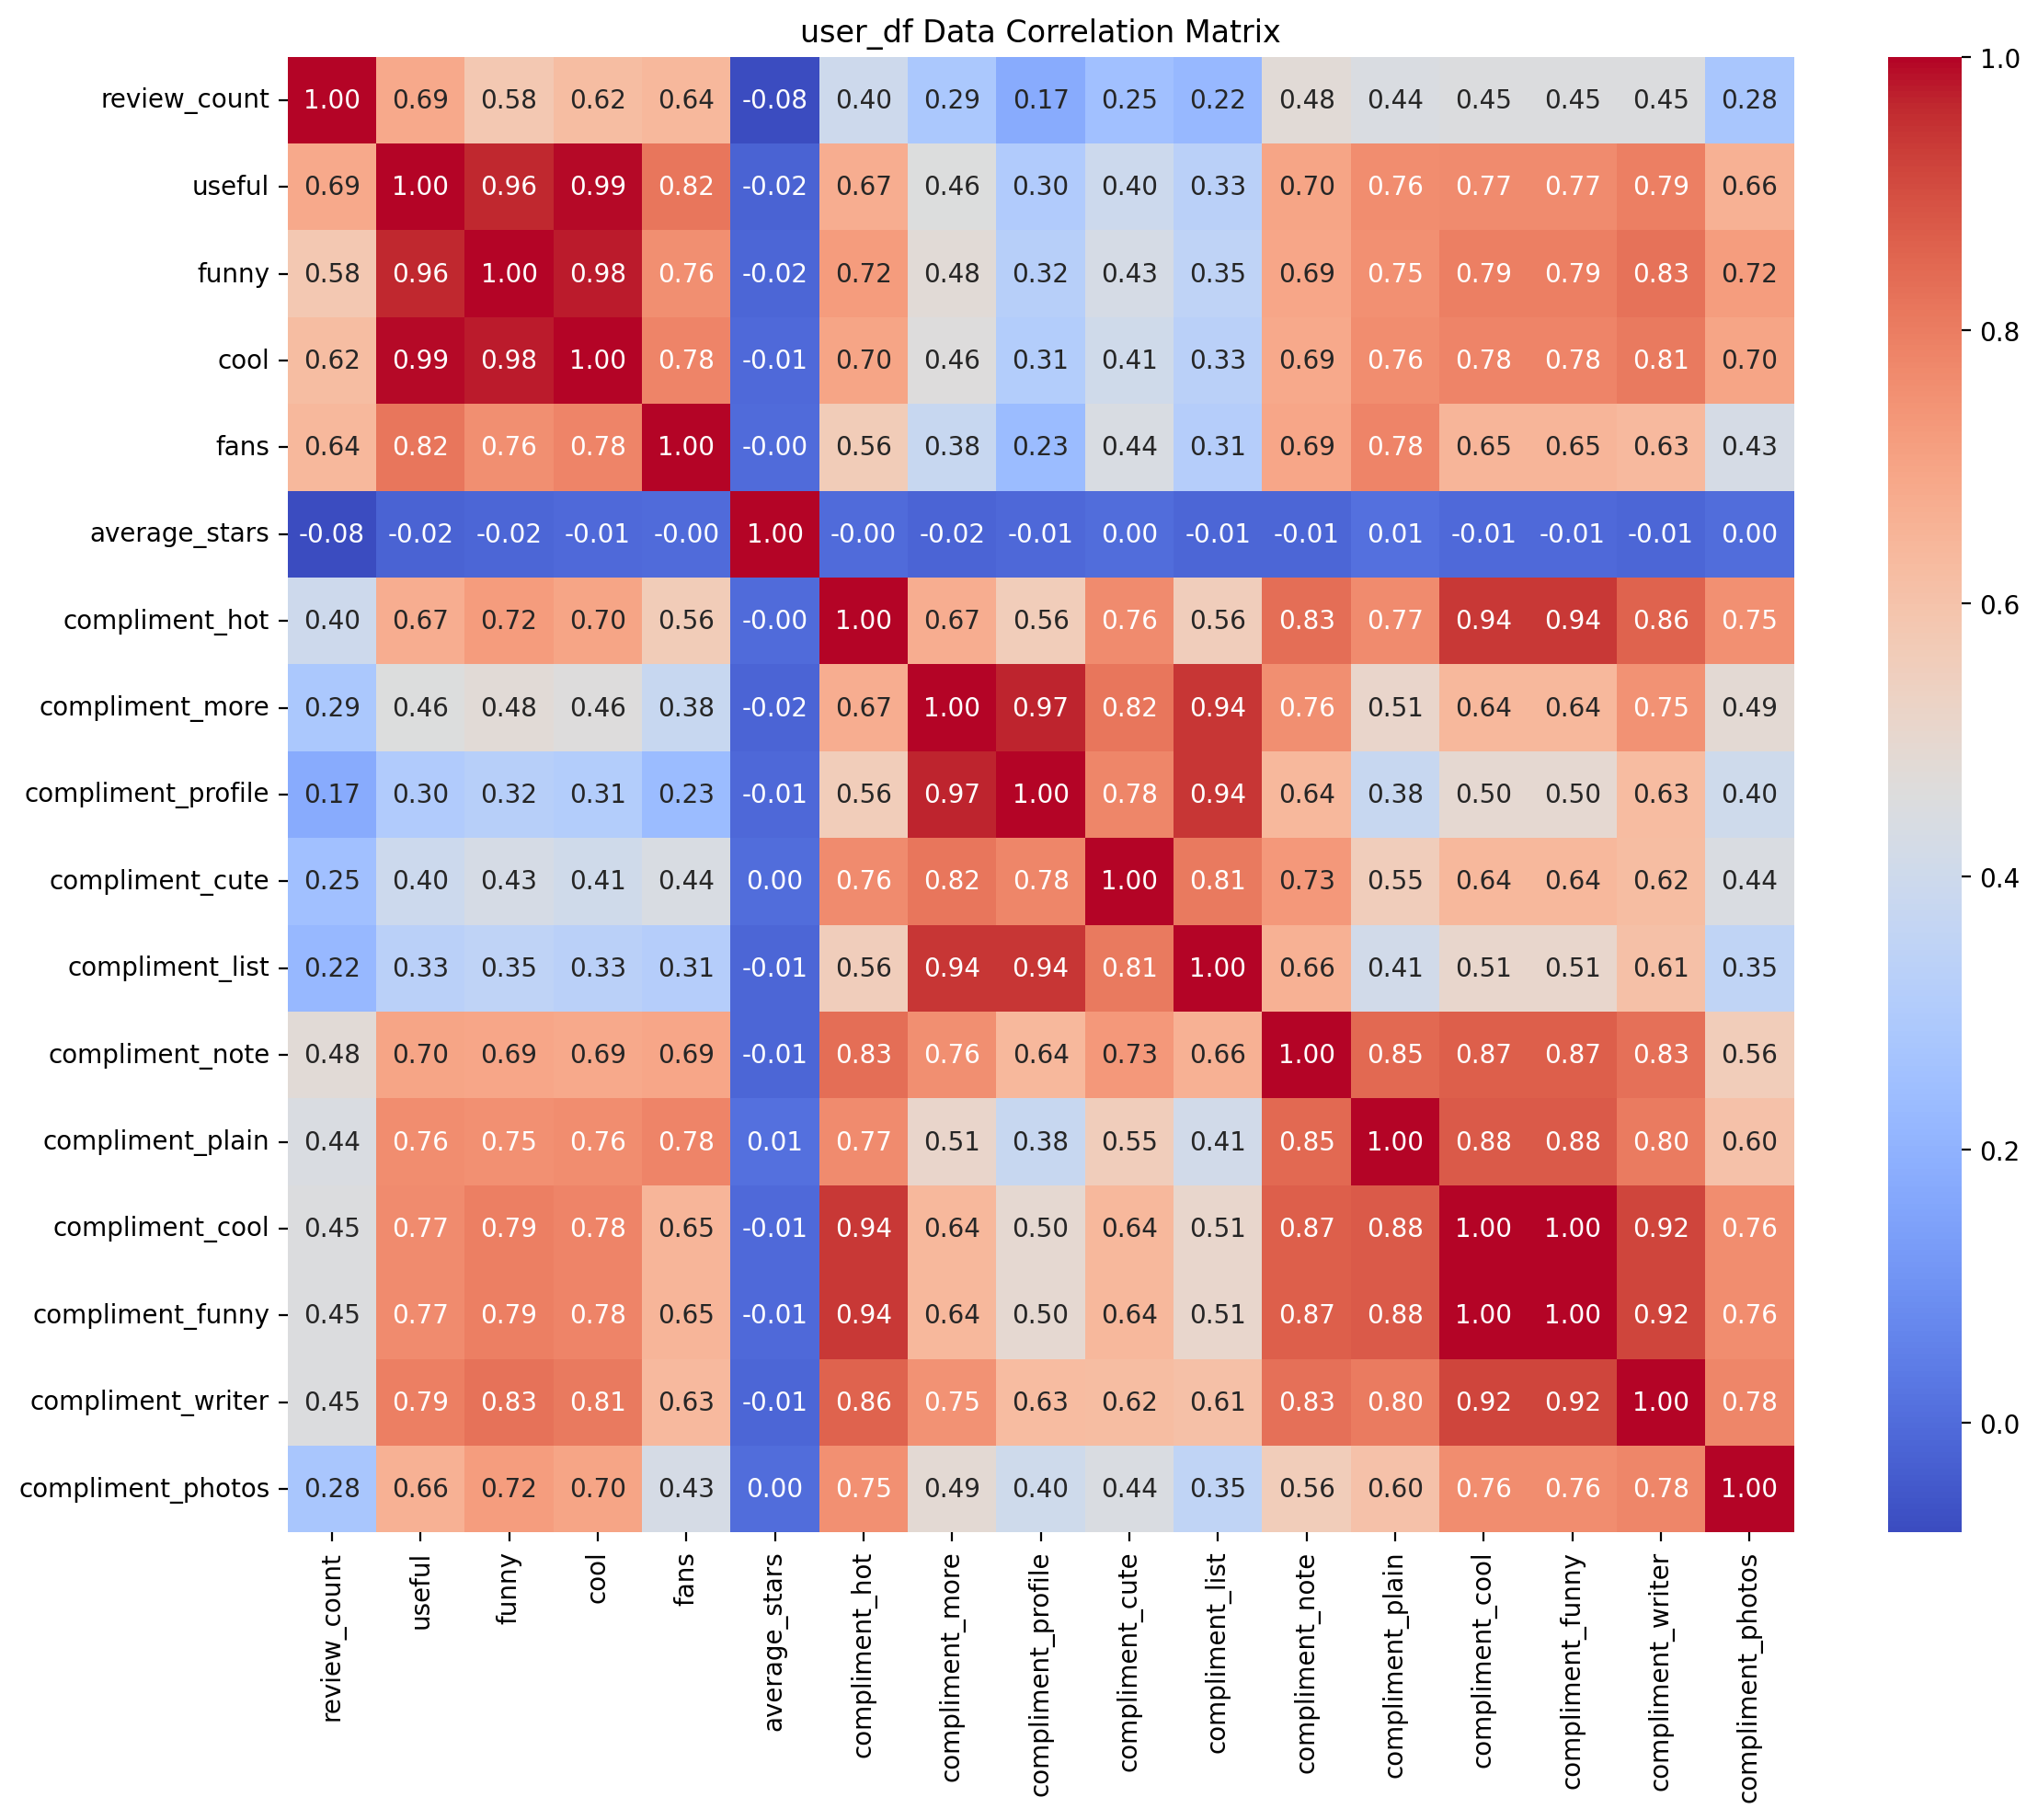

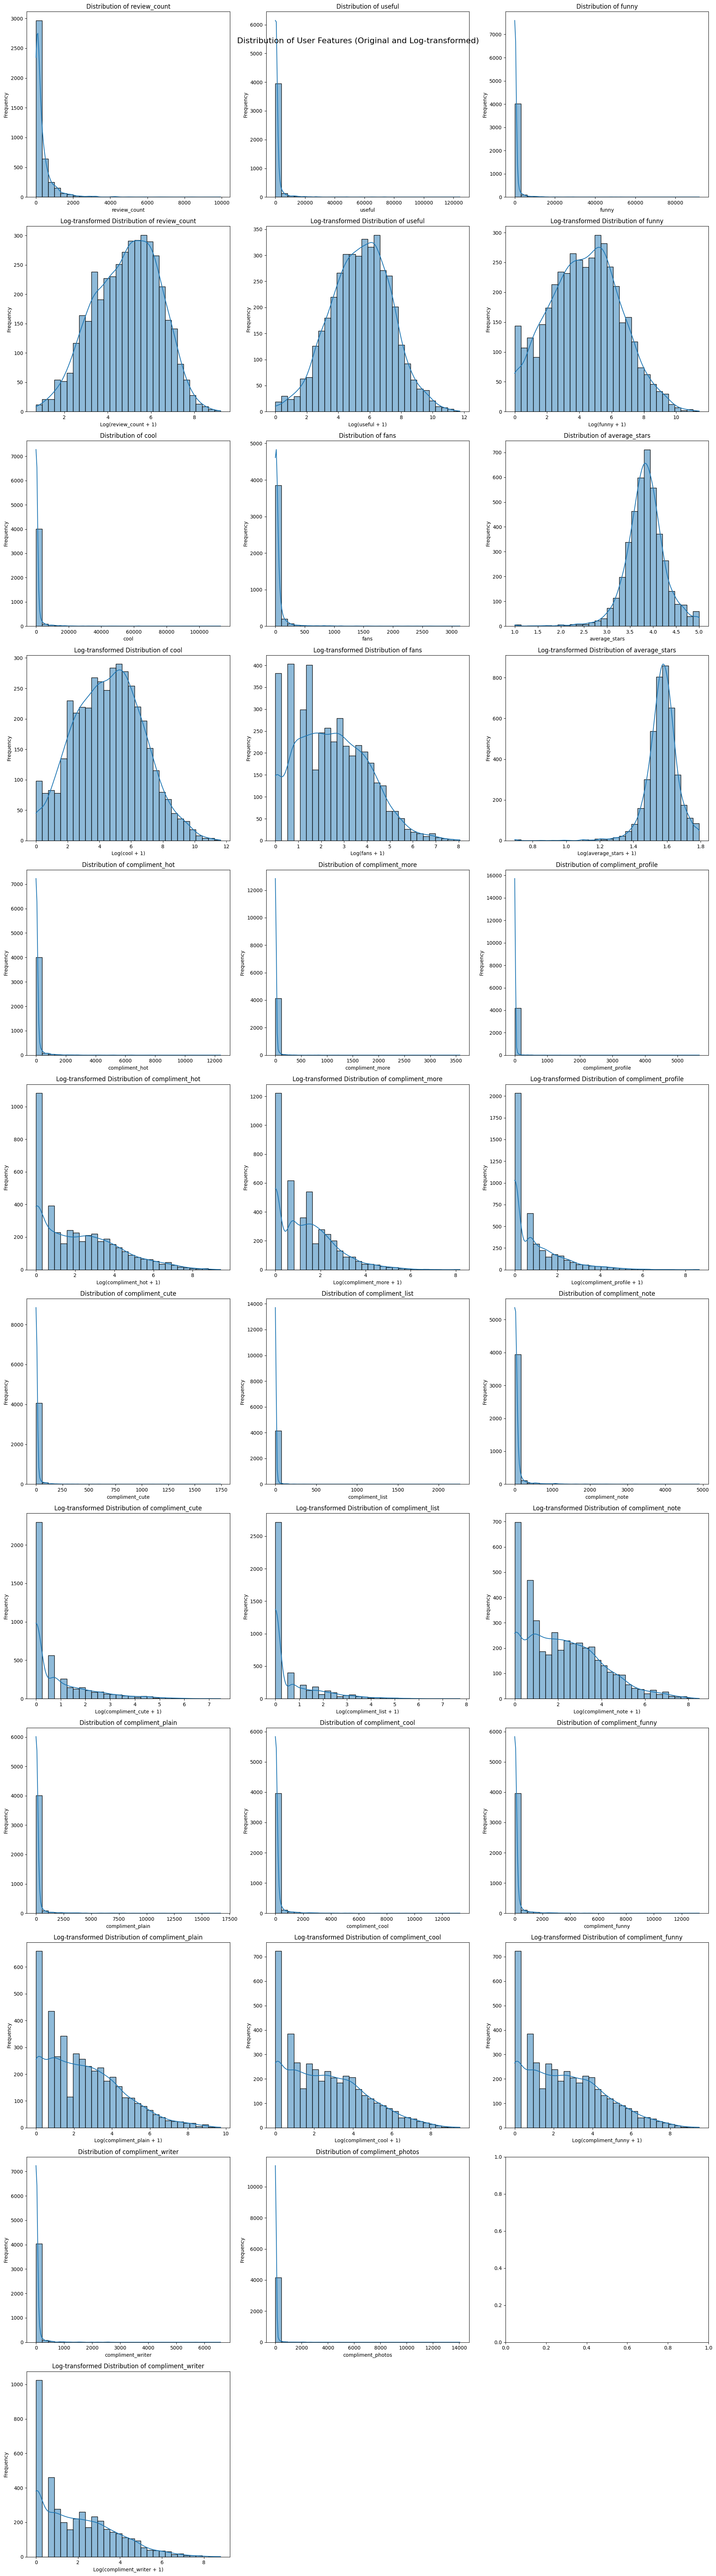

Finished processing user_df


In [6]:
def compute_and_plot_correlation(data, title):
    corr = data.corr(numeric_only=True).compute()
    plt.figure(figsize=(12, 10), dpi=200)
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title(f'{title} Correlation Matrix')
    plt.tight_layout()
    plt.savefig(f'{title.lower().replace(" ", "_")}_correlation.png', dpi=200)
    plt.show()

def plot_kde(data, columns, title, xlabel, ylabel):
    data.loc[:, columns].compute().plot.kde()
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.savefig(f'{title.lower().replace(" ", "_")}.png', dpi=200)
    plt.show()

def plot_histogram(data, column, title, xlabel, ylabel, bins=20, log_transform=False):
    plt.figure(figsize=(12, 8), dpi=200)
    data_computed = data.loc[:, [column]].compute()
    
    if log_transform:
        data_computed['log_' + column] = np.log1p(data_computed[column])
        plt.hist(data_computed['log_' + column], bins=bins)
        xlabel = f'Log-Transformed {xlabel}'
    else:
        plt.hist(data_computed[column], bins=bins, edgecolor='black')
    
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.savefig(f'{title.lower().replace(" ", "_")}.png', dpi=200)
    plt.show()

def plot_review_metrics_kde(data, columns):
    data_review = data.loc[:, columns].compute()
    data_review_log = np.log1p(data_review)
    
    fig, ax = plt.subplots(figsize=(20, 10), dpi=200)
    data_review_log.plot.kde(ax=ax, alpha=0.5)
    ax.set_title('KDE of Review Metrics')
    ax.set_xlabel('Value')
    ax.set_ylabel('Density')
    plt.savefig('review_metrics_kde.png', dpi=200)
    plt.show()

def plot_geographical_distribution(data):
    businesses = data.compute()
    plt.figure(figsize=(10, 8), dpi=200)
    plt.scatter(businesses['longitude'], businesses['latitude'], alpha=0.5, c='blue', s=10)
    plt.title('Geographical Distribution of Businesses')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.savefig('geographical_distribution.png', dpi=200)
    plt.show()

def plot_category_counts(data):
    businesses = data.compute()
    category_counts = businesses['categories'].explode().value_counts().head(50)
    plt.figure(figsize=(20, 10), dpi=200)
    sns.barplot(x=category_counts.index, y=category_counts.values)
    plt.title('Number of Businesses per Category')
    plt.xlabel('Category')
    plt.ylabel('Number of Businesses')
    plt.xticks(rotation=90)
    plt.savefig('category_counts.png', dpi=200)
    plt.show()


def plot_user_distributions(df):
    numerical_features = [
        'review_count', 'useful', 'funny', 'cool', 'fans', 'average_stars'
    ] + [col for col in df.columns if 'compliment' in col]
    
    data = df[numerical_features].compute()
    data_log = np.log1p(data)
    
    n_cols = 3
    n_rows = 2 * ((len(numerical_features) + n_cols - 1) // n_cols)
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 6*n_rows))
    fig.suptitle('Distribution of User Features (Original and Log-transformed)', fontsize=16)
    
    for i, feature in enumerate(numerical_features):
        # Original distribution
        ax1 = axes[2*(i // n_cols), i % n_cols]
        sns.histplot(data[feature], bins=30, kde=True, ax=ax1)
        ax1.set_title(f'Distribution of {feature}')
        ax1.set_xlabel(feature)
        ax1.set_ylabel('Frequency')
        
        # Log-transformed distribution
        ax2 = axes[2*(i // n_cols) + 1, i % n_cols]
        sns.histplot(data_log[feature], bins=30, kde=True, ax=ax2)
        ax2.set_title(f'Log-transformed Distribution of {feature}')
        ax2.set_xlabel(f'Log({feature} + 1)')
        ax2.set_ylabel('Frequency')
    
    # Remove any unused subplots
    for i in range(2*len(numerical_features), n_rows * n_cols):
        fig.delaxes(axes[i // n_cols, i % n_cols])
    
    plt.tight_layout()
    plt.savefig('user_distributions_original_and_log.png', dpi=200)
    plt.show()

# Define the dictionary of dataframes
df_corr = {
    'bus_df': data_businesses,
    'tip_df': data_tip,
    'review_df': data_review_sample,
    'user_df': data_user_sample
}

# Main execution
for df_name, df in df_corr.items():
    print(f"\nProcessing {df_name}:")
    
    # Correlation plot for all dataframes
    compute_and_plot_correlation(df, f'{df_name} Data') 
    
    # Specific plots for each dataframe
    if df_name == 'bus_df':
        plot_geographical_distribution(df)
        plot_category_counts(df)
        plot_histogram(df, 'stars', 'Distribution of Business Ratings', 'Star Rating', 'Frequency')
        plot_histogram(df, 'review_count', 'Histogram of Review Counts', 'Review Count', 'Frequency', bins=100)
        plot_histogram(df, 'review_count', 'Histogram of Log-Transformed Review Counts', 'Review Count', 'Frequency', bins=100, log_transform=True)
    
    elif df_name == 'checkin_df':
        # Add specific plots for checkin data if needed
        pass
    
    elif df_name == 'tip_df':
        # Add specific plots for tip data if needed
        pass
    
    elif df_name == 'review_df':
        plot_review_metrics_kde(df, ['stars', 'useful', 'funny', 'cool'])
    
    elif df_name == 'user_df':
        # Add specific plots for user data if needed
        plot_user_distributions(df)
        

    print(f"Finished processing {df_name}")

# If you want to display the description of the log-transformed review data
# print(np.log1p(data_review_sample.loc[:, ['stars', 'useful', 'funny', 'cool']].compute()).describe())

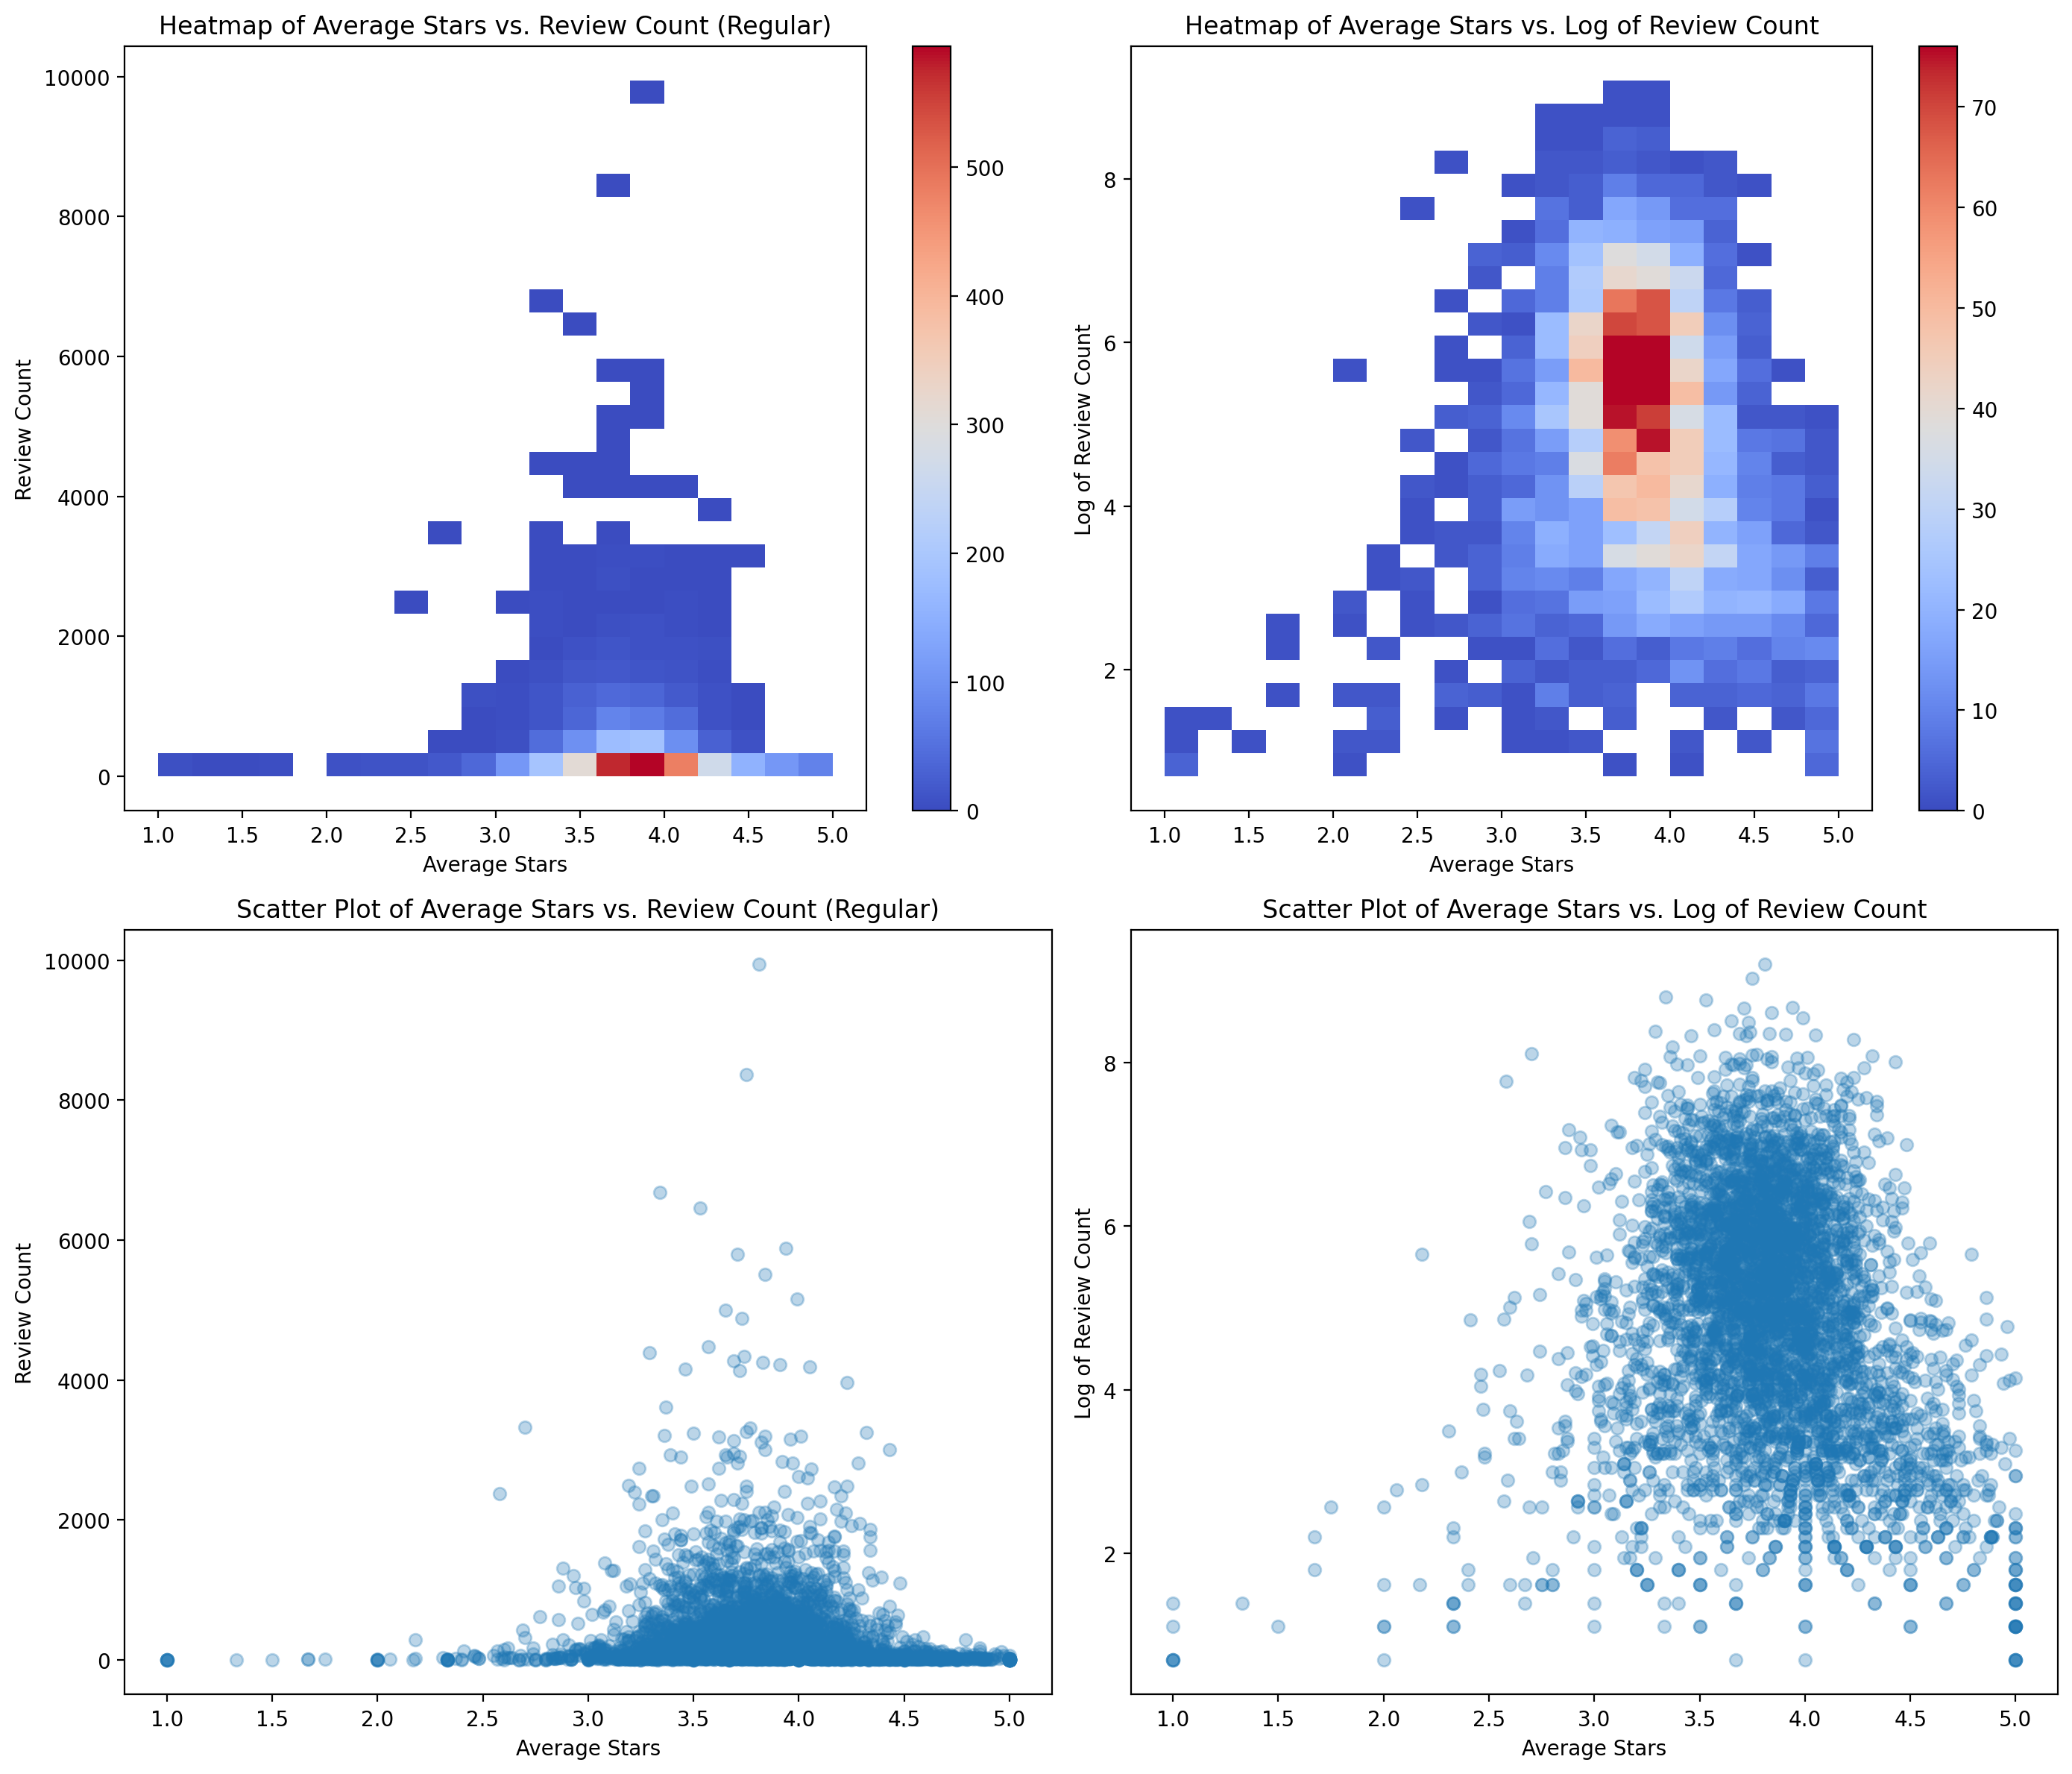

In [51]:
# Compute the data
data = data_user_sample.compute()

# Add log-transformed review count
data['log_review_count'] = np.log1p(data['review_count'])

# Set up the plotting area with subplots
fig, ax = plt.subplots(2, 2, figsize=(14, 12), dpi=200)

# Titles for the plots
title = "data_user_sample"  # Use a descriptive title for the DataFrame

# Heatmap of regular review count vs. average stars
sns.histplot(
    data=data,
    x='average_stars',
    y='review_count',
    bins=(20, 30),
    pmax=.9,
    cbar=True,
    cmap='coolwarm',
    ax=ax[0, 0]
)
ax[0, 0].set_xlabel('Average Stars')
ax[0, 0].set_ylabel('Review Count')
ax[0, 0].set_title('Heatmap of Average Stars vs. Review Count (Regular)')

# Heatmap of log-transformed review count vs. average stars
sns.histplot(
    data=data,
    x='average_stars',
    y='log_review_count',
    bins=(20, 30),
    pmax=.9,
    cbar=True,
    cmap='coolwarm',
    ax=ax[0, 1]
)
ax[0, 1].set_xlabel('Average Stars')
ax[0, 1].set_ylabel('Log of Review Count')
ax[0, 1].set_title('Heatmap of Average Stars vs. Log of Review Count')

# Scatter plot of regular review count vs. average stars
ax[1, 0].scatter(data['average_stars'], data['review_count'], alpha=0.3)
ax[1, 0].set_xlabel('Average Stars')
ax[1, 0].set_ylabel('Review Count')
ax[1, 0].set_title('Scatter Plot of Average Stars vs. Review Count (Regular)')

# Scatter plot of log-transformed review count vs. average stars
ax[1, 1].scatter(data['average_stars'], data['log_review_count'], alpha=0.3)
ax[1, 1].set_xlabel('Average Stars')
ax[1, 1].set_ylabel('Log of Review Count')
ax[1, 1].set_title('Scatter Plot of Average Stars vs. Log of Review Count')

# Adjust layout
plt.tight_layout()

# Save the figure
plt.savefig(f'User_df_avgStars_vs_reviewCounts_plots.png')

# Show the figure
plt.show()

Notice in the graph above how the average rating tends to converge towards a mean as the number of reviews increases. This aligns with the Central Limit Theorem (CLT), showing that the average rating becomes more stable with more reviews. Observe how the spread of average stars is wider for users with fewer reviews, indicating that users who review less are more likely to have ratings that are on the extremes—either very high or very low. This reflects that users with fewer reviews tend to show more variability in their satisfaction levels.

In [64]:
# data_businesses.compute().info()

In [60]:
# Compute the data to convert it to a Pandas DataFrame
# data_businesses = data_businesses.compute()

# Initialize the map centered around the mean coordinates
center_lat = data_businesses['latitude'].mean()
center_lon = data_businesses['longitude'].mean()


# Initialize the map
m = folium.Map(location=[center_lat, center_lon], zoom_start=12)

# Add clustering
marker_cluster = MarkerCluster().add_to(m)

# Add markers to the cluster
for _, row in data_businesses.iterrows():
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=row['name']
    ).add_to(marker_cluster)

# Save the map
m.save('business_map_folium_clustering.html')

In [155]:
dr = data_review_sample.compute().copy()

dr['year'] = dr['date'].dt.year
dr['month'] = dr['date'].dt.month

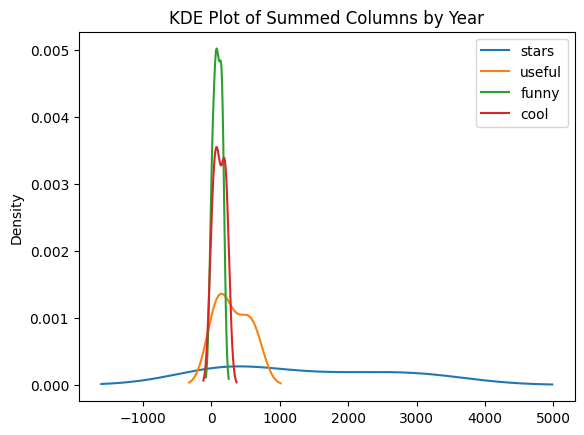

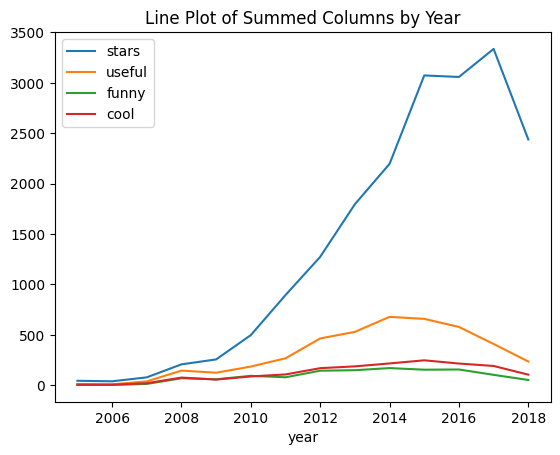

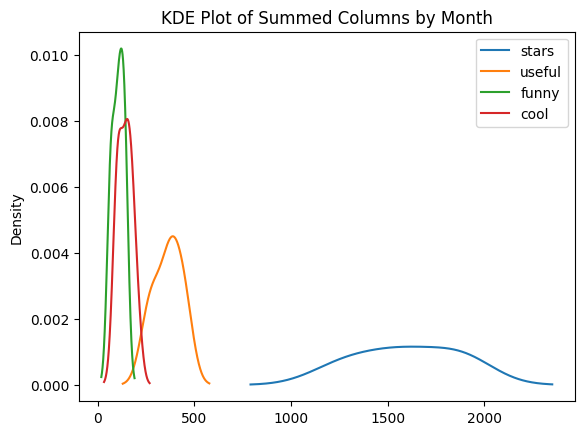

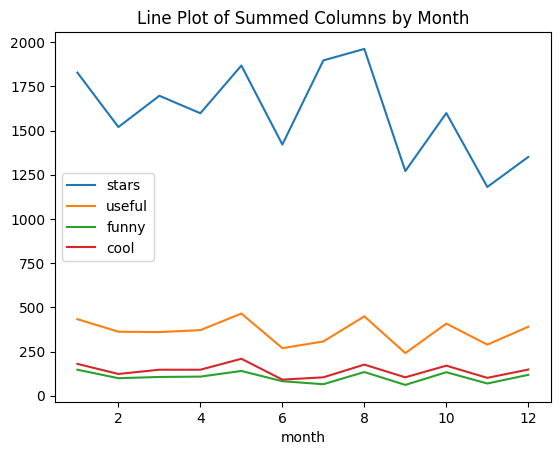

In [65]:
# Group by year and month
res = dr.groupby('year')[['stars', 'useful', 'funny', 'cool']].sum()
ult = dr.groupby('month')[['stars', 'useful', 'funny', 'cool']].sum()

res.plot(kind='kde', title='KDE Plot of Summed Columns by Year')
res.plot(title='Line Plot of Summed Columns by Year')

ult.plot(kind='kde', title='KDE Plot of Summed Columns by Month')
ult.plot(title='Line Plot of Summed Columns by Month')

plt.show()

In [151]:
# dr.head() 

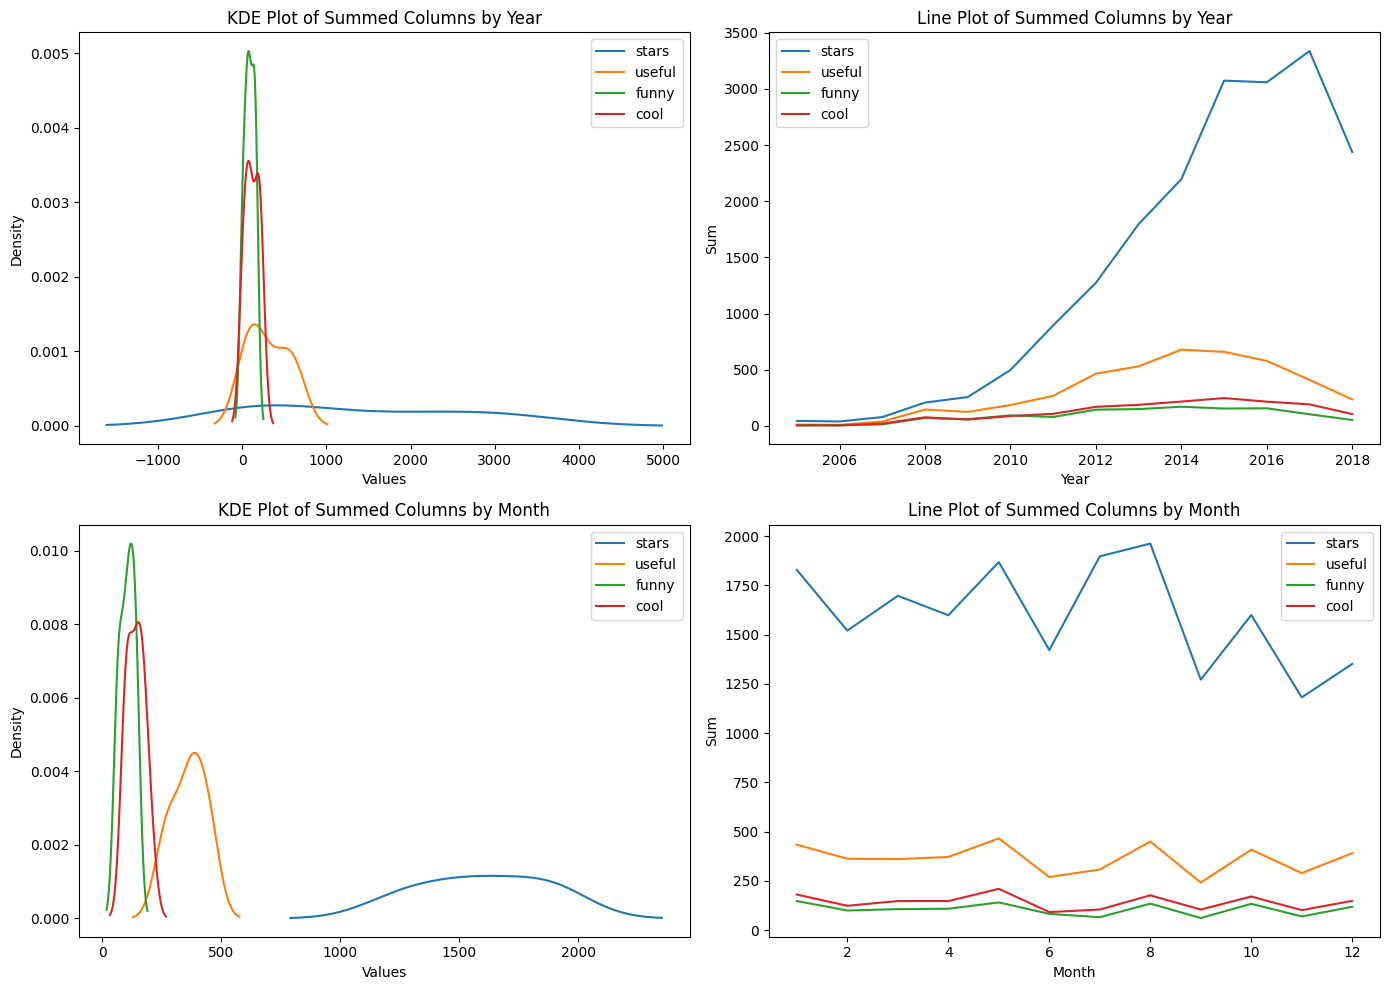

In [163]:
# Group by year and month
res = dr.groupby('year')[['stars', 'useful', 'funny', 'cool']].sum()
ult = dr.groupby('month')[['stars', 'useful', 'funny', 'cool']].sum()

fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Plot KDE for summed columns by Year
res.plot(kind='kde', ax=axs[0, 0])
axs[0, 0].set_title('KDE Plot of Summed Columns by Year')
axs[0, 0].set_xlabel('Values')
axs[0, 0].set_ylabel('Density')

# Plot Line for summed columns by Year
res.plot(ax=axs[0, 1])
axs[0, 1].set_title('Line Plot of Summed Columns by Year')
axs[0, 1].set_xlabel('Year')
axs[0, 1].set_ylabel('Sum')

# Plot KDE for summed columns by Month
ult.plot(kind='kde', ax=axs[1, 0])
axs[1, 0].set_title('KDE Plot of Summed Columns by Month')
axs[1, 0].set_xlabel('Values')
axs[1, 0].set_ylabel('Density')

# Plot Line for summed columns by Month
ult.plot(ax=axs[1, 1])
axs[1, 1].set_title('Line Plot of Summed Columns by Month')
axs[1, 1].set_xlabel('Month')
axs[1, 1].set_ylabel('Sum')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

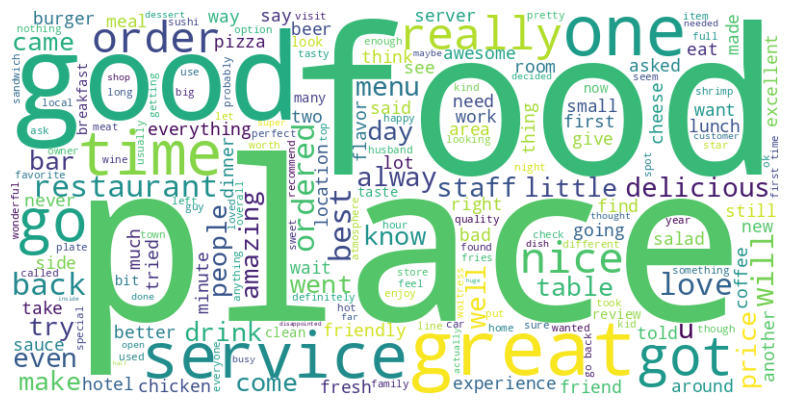

In [60]:

review_text = ' '.join(data_review_sample['text'].dropna())

# Generate the word cloud for comapny reviews
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(review_text)


plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  
plt.show()

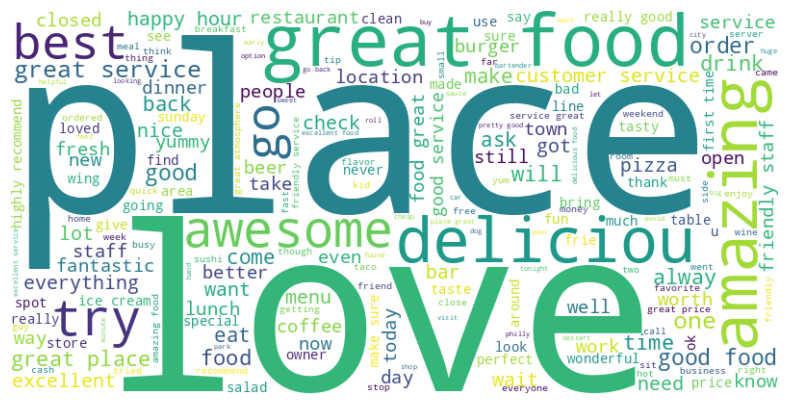

In [62]:
# Generate the word cloud for company tips

tip_text = ' '.join(data_tip['text'].dropna())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(tip_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off') 
plt.show()

Distribution of Reviews via Textblob Sentiment Analyzer
Number of positive reviews: 4429
Number of neutral reviews: 20
Number of negative reviews: 551


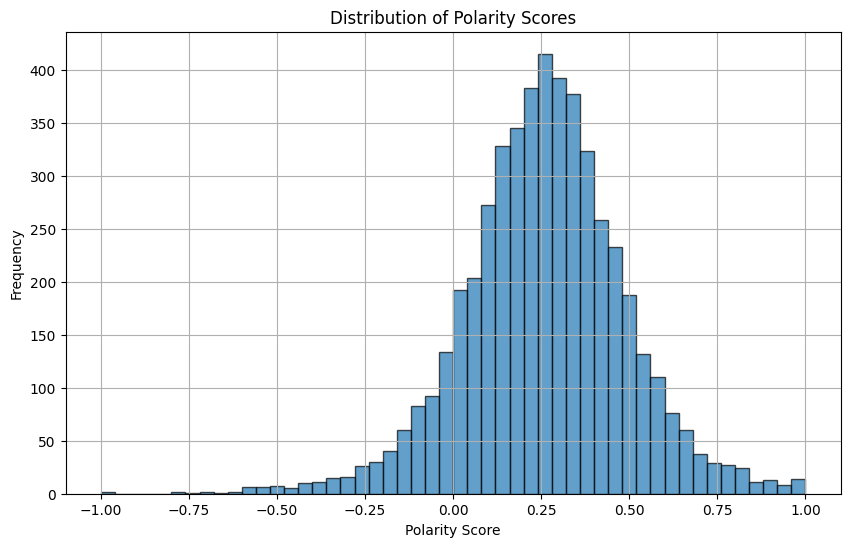

In [162]:
# Function to classify sentiment
def get_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity

# Apply sentiment analysis to reviews
dr['polarity_score'] = dr['text'].apply(get_sentiment)

# Classify sentiment based on polarity score
def classify_sentiment(score):
    if score > 0:
        return 'positive'
    elif score < 0:
        return 'negative'
    else:
        return 'neutral'

dr['sentiment_txt_blob'] = dr['polarity_score'].apply(classify_sentiment)

# Count the number of positive, neutral, and negative reviews
sentiment_counts = dr['sentiment_txt_blob'].value_counts()

# Print counts
print(f"Distribution of Reviews via Textblob Sentiment Analyzer")
print("Number of positive reviews:", sentiment_counts.get('positive', 0))
print("Number of neutral reviews:", sentiment_counts.get('neutral', 0))
print("Number of negative reviews:", sentiment_counts.get('negative', 0))

# Plot the distribution of polarity scores
plt.figure(figsize=(10, 6))
dr['polarity_score'].plot(kind='hist', bins=50, edgecolor='black', alpha=0.7)
plt.title('Distribution of Polarity Scores')
plt.xlabel('Polarity Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


Number of positive reviews: 4360
Number of neutral reviews: 35
Number of negative reviews: 605


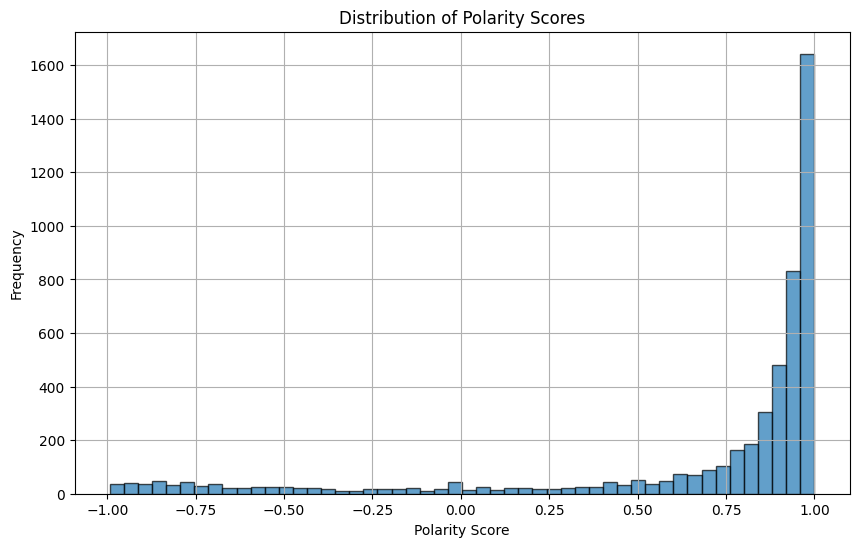

In [159]:
# Function to get polarity score
def get_sentiment_vader(text):
    sia = SentimentIntensityAnalyzer()
    return sia.polarity_scores(text)['compound']

# Apply sentiment analysis to reviews
dr['polarity_score'] = dr['text'].apply(get_sentiment_vader)

# Classify reviews
def classify_sentiment(score):
    if score > 0:
        return 'positive'
    elif score < 0:
        return 'negative'
    else:
        return 'neutral'


dr['sentiment'] = dr['polarity_score'].apply(classify_sentiment)

# Count the number of positive, neutral, and negative reviews
sentiment_counts = dr['sentiment'].value_counts()

# Print counts
print(f"Distribution of Reviews via NTLK Sentiment Analyzer")
print("Number of positive reviews:", sentiment_counts.get('positive', 0))
print("Number of neutral reviews:", sentiment_counts.get('neutral', 0))
print("Number of negative reviews:", sentiment_counts.get('negative', 0))

# Plot the distribution of polarity scores
plt.figure(figsize=(10, 6))
dr['polarity_score'].plot(kind='hist', bins=50, edgecolor='black', alpha=0.7)
plt.title('Distribution of Polarity Scores')
plt.xlabel('Polarity Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

Both methods indicate positive sentiment but with different distributions. The NLTK results show a stronger concentration of positive sentiment, this suggests a higher degree of satisfaction or a skew in review behavior. The TextBlob results provide a more balanced view with moderate positivity.

In [35]:
def token_lemmatizer(text):
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))
    tokens = word_tokenize(text)
    return [lemmatizer.lemmatize(word) for word in tokens if word.lower() not in stop_words]

def process_text(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation + string.digits))
    return token_lemmatizer(text)

def apply_ngram(tokens, n):
    return list(ngrams(tokens, n))

@delayed
def count_ngrams(ngrams_list):
    return Counter(ngram for sublist in ngrams_list for ngram in sublist)

def ngram(df, n=2, text_col='text'):
    # Process the text column
    df[f"tokens_{text_col}"] = df[text_col].map(process_text, meta=('x', 'object'))
    
    # Apply n-gram generation
    df[f"ngrams_{text_col}_{n}"] = df[f"tokens_{text_col}"].map(lambda tokens: apply_ngram(tokens, n), meta=('x', 'object'))
    
    # Count n-grams
    ngram_counts = df[f"ngrams_{text_col}_{n}"].compute().tolist()
    global_counter = count_ngrams(ngram_counts)
    
    return df, global_counter

In [37]:
df_review_bigram, bigram_counter = ngram(data_review_sample, n=2)
df_review_trigram, trigram_counter = ngram(data_review_sample, n=3)

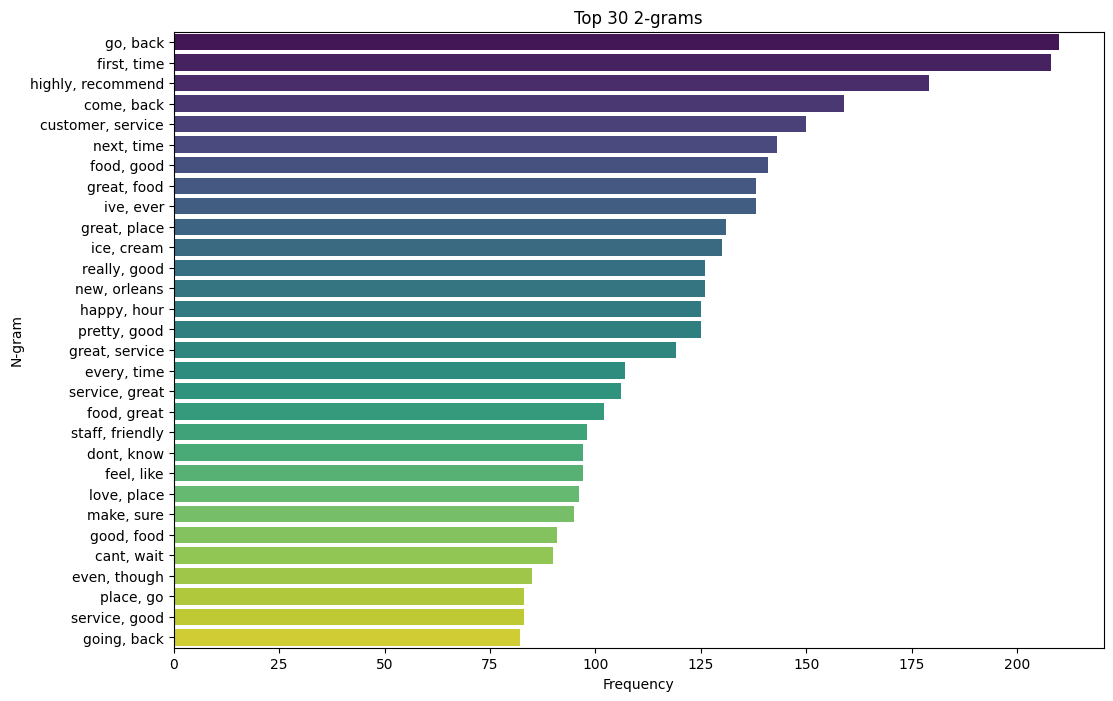

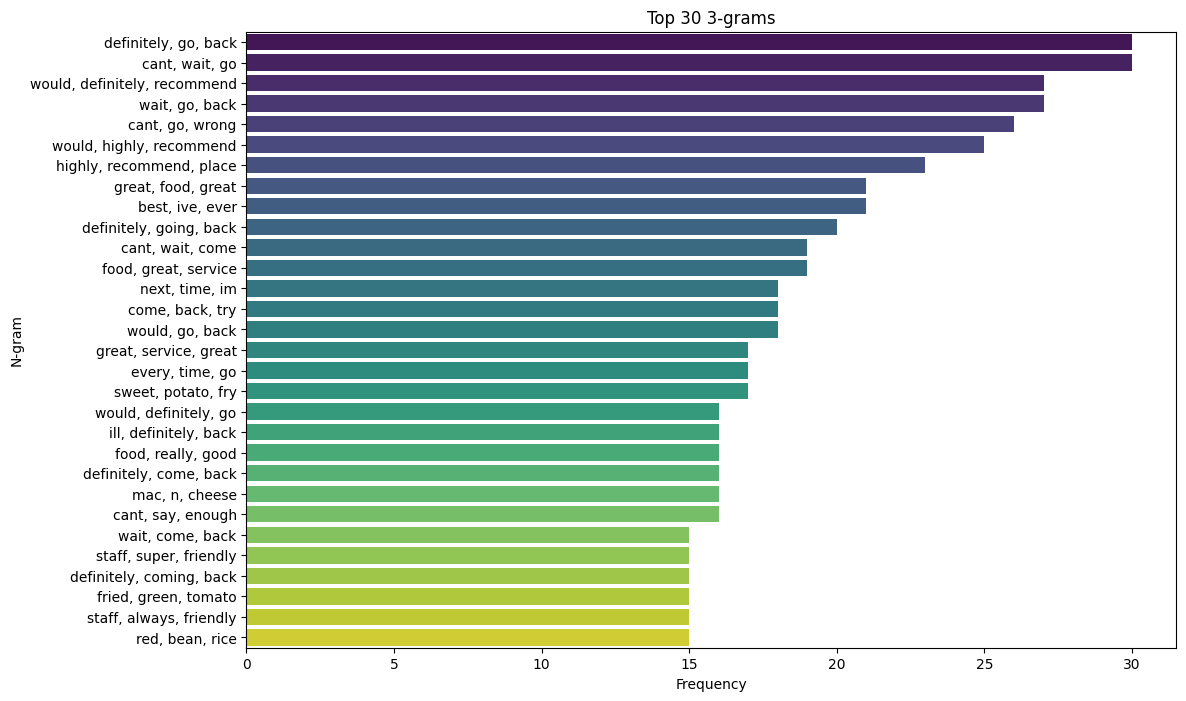

In [40]:
def plot_top_k_ngrams(ngram_counter, n=2, top_k=10):
    # Get the top k most common n-grams
    most_common_ngrams = ngram_counter.most_common(top_k)
    ngrams, counts = zip(*most_common_ngrams)
    
    # Create a DataFrame for plotting
    ngram_df = pd.DataFrame({
        'N-gram': [', '.join(ngram) for ngram in ngrams],
        'Frequency': counts
    })
    
    # Plot the top k n-grams
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Frequency', y=f"N-gram", data=ngram_df, palette='viridis')
    plt.xlabel('Frequency')
    plt.ylabel('N-gram')
    plt.title(f'Top {top_k} {n}-grams')
    plt.show()


plot_top_k_ngrams(bigram_counter.compute(), n=2, top_k=30)
plot_top_k_ngrams(trigram_counter.compute(), n=3, top_k=30)

In [168]:
# data_businesses.compute().loc['---kPU91CF4Lq2-WlRu9Lw', 'attributes']

In [172]:
data_user_sample.compute().describe()

review_count                  yelping_since         useful  \
count   4211.000000                           4211    4211.000000   
mean     341.816671  2009-05-08 13:15:50.810496512    1275.876276   
min        1.000000            2005-01-03 18:01:35       0.000000   
25%       42.000000            2008-03-15 06:30:46      60.000000   
50%      145.000000            2009-06-18 21:29:13     244.000000   
75%      399.000000     2010-08-03 00:38:08.500000     868.000000   
max     9941.000000            2013-07-30 17:49:45  124311.000000   
std      582.808313                            NaN    4488.603479   

              funny           cool         fans  average_stars  \
count   4211.000000    4211.000000  4211.000000    4211.000000   
mean     684.314890     883.991926    44.503681       3.830869   
min        0.000000       0.000000     0.000000       1.000000   
25%       15.000000      19.000000     2.000000       3.600000   
50%       79.000000     101.000000    10.000000       3.830000   
75%      344.500000     436.500000    36.000000       4.060000   
max    91842.000000  113069.000000  3138.000000       5.000000   
std     2908.094407    3755.493255   142.928365       0.431512   

       compliment_hot  compliment_more  compliment_profile  compliment_cute  \
count     4211.000000      4211.000000         4211.000000      4211.000000   
mean        93.666588        11.848730            9.772738         8.834244   
min          0.000000         0.000000            0.000000         0.000000   
25%          0.000000         0.000000            0.000000         0.000000   
50%          5.000000         2.000000            1.000000         0.000000   
75%         33.000000         7.000000            3.000000         3.000000   
max      12391.000000      3575.000000         5662.000000      1744.000000   
std        433.074690        69.657934           98.640596        51.187551   

       compliment_list  compliment_note  compliment_plain  compliment_cool  \
count      4211.000000      4211.000000       4211.000000      4211.000000   
mean          5.336737        56.616481        144.450724       128.450962   
min           0.000000         0.000000          0.000000         0.000000   
25%           0.000000         1.000000          1.000000         1.000000   
50%           0.000000         7.000000          9.000000        10.000000   
75%           2.000000        28.000000         45.000000        51.000000   
max        2261.000000      4901.000000      16674.000000     13262.000000   
std          44.008681       218.024305        714.616047       562.896788   

       compliment_funny  compliment_writer  compliment_photos  
count       4211.000000        4211.000000        4211.000000  
mean         128.450962          48.126098          37.050344  
min            0.000000           0.000000           0.000000  
25%            1.000000           1.000000           0.000000  
50%           10.000000           4.000000           1.000000  
75%           51.000000          22.500000           6.000000  
max        13262.000000        6574.000000       14045.000000  
std          562.896788         223.647099         342.897864

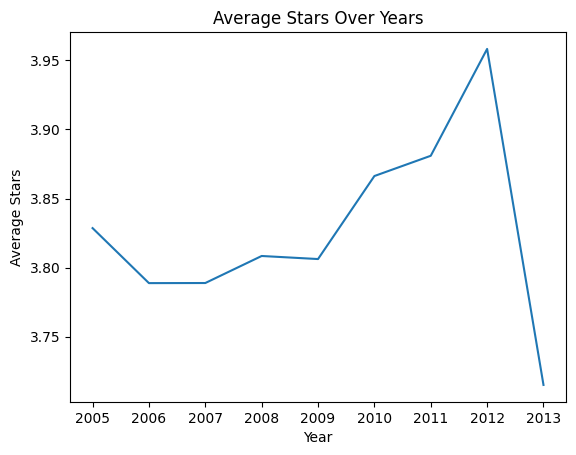

In [173]:
df = data_user_sample.compute()
df['yelping_since'] = pd.to_datetime(df['yelping_since'], format='%Y')
df['year'] = df['yelping_since'].dt.year

# Plot trend of average stars over years
df.groupby('year')['average_stars'].mean().plot()
plt.title('Average Stars Over Years')
plt.xlabel('Year')
plt.ylabel('Average Stars')
plt.show()

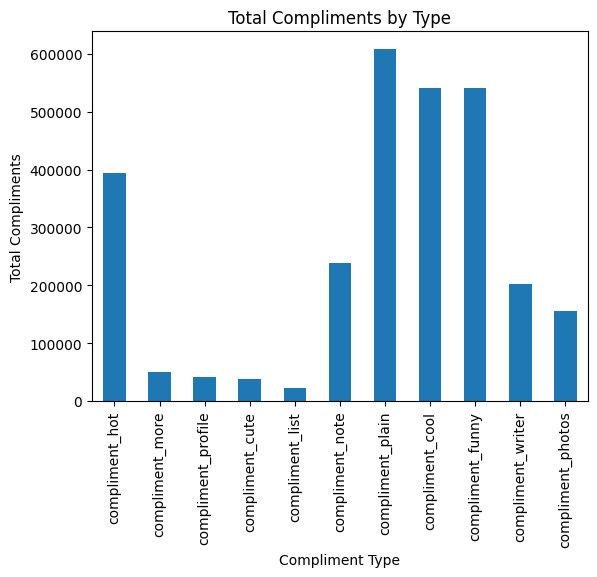

In [177]:
compliment_cols = [
    'compliment_hot', 'compliment_more', 'compliment_profile', 'compliment_cute', 
    'compliment_list', 'compliment_note', 'compliment_plain', 'compliment_cool', 
    'compliment_funny', 'compliment_writer', 'compliment_photos'
]

df[compliment_cols].sum().plot(kind='bar')
plt.title('Total Compliments by Type')
plt.xlabel('Compliment Type')
plt.ylabel('Total Compliments')
plt.show()

In [178]:
data_user_sample.head()

name  review_count       yelping_since  useful  \
user_id                                                                    
--KsuCSkGGvDKTbdK9NvIg   C-Mac            57 2010-10-02 11:59:35      68   
--ccVMj2PN6Z9qtdOdlung   Kacie            15 2008-08-06 20:39:47      59   
--qijw7qsKsG-v6rreDOAA  Amelia            23 2010-02-03 16:57:23      14   
-4RbxLJlFZlu-KRuUiiGLw  Autumn            66 2008-09-13 04:37:14     240   
-4swZSBw5Qdk5VRqB7kw1A     Tom            30 2011-02-13 21:47:31      67   

                        funny  cool elite  \
user_id                                     
--KsuCSkGGvDKTbdK9NvIg     16    28    []   
--ccVMj2PN6Z9qtdOdlung     33    55    []   
--qijw7qsKsG-v6rreDOAA      5    10    []   
-4RbxLJlFZlu-KRuUiiGLw     50   130    []   
-4swZSBw5Qdk5VRqB7kw1A      4     6    []   

                                                                  friends  \
user_id                                                                     
--KsuCSkGGvDKTbdK9NvIg  [TcqGIB4Pbz6TtZu3PxLfVg, dDwwmnPyzSiNaD3yix_Ev...   
--ccVMj2PN6Z9qtdOdlung  [jCfyi8mOBqMJrj_DZFalgg, 0koQMZk1diY9f1gOv3nmP...   
--qijw7qsKsG-v6rreDOAA  [KQcfYKxkZIwLak-85Us7eA, bqjAhIGARynspNvUp2dQ3...   
-4RbxLJlFZlu-KRuUiiGLw  [OapLWhQI4_Gm32-nYbHmUA, NNgQ8fV5ARQgHw-Ob7l50...   
-4swZSBw5Qdk5VRqB7kw1A  [A-ZQRbFI3xQbsyhzV0rRBg, JwV8ZSQz2T19eaDTcCUkd...   

                        fans  average_stars  ...  compliment_more  \
user_id                                      ...                    
--KsuCSkGGvDKTbdK9NvIg     5           3.93  ...                0   
--ccVMj2PN6Z9qtdOdlung     2           3.67  ...                0   
--qijw7qsKsG-v6rreDOAA     4           4.37  ...                1   
-4RbxLJlFZlu-KRuUiiGLw     8           4.13  ...                2   
-4swZSBw5Qdk5VRqB7kw1A     0           3.48  ...                0   

                        compliment_profile  compliment_cute  compliment_list  \
user_id                                                                        
--KsuCSkGGvDKTbdK9NvIg                   1                0                0   
--ccVMj2PN6Z9qtdOdlung                   0                0                0   
--qijw7qsKsG-v6rreDOAA                   1                0                0   
-4RbxLJlFZlu-KRuUiiGLw                   0                1                0   
-4swZSBw5Qdk5VRqB7kw1A                   0                0                0   

                        compliment_note  compliment_plain  compliment_cool  \
user_id                                                                      
--KsuCSkGGvDKTbdK9NvIg                2                 5                8   
--ccVMj2PN6Z9qtdOdlung                4                 1                3   
--qijw7qsKsG-v6rreDOAA                0                 0                0   
-4RbxLJlFZlu-KRuUiiGLw                3                 6               19   
-4swZSBw5Qdk5VRqB7kw1A                1                 1                0   

                        compliment_funny  compliment_writer  compliment_photos  
user_id                                                                         
--KsuCSkGGvDKTbdK9NvIg                 8                  5                  2  
--ccVMj2PN6Z9qtdOdlung                 3                  1                  0  
--qijw7qsKsG-v6rreDOAA                 0                  0                  0  
-4RbxLJlFZlu-KRuUiiGLw                19                  0                  5  
-4swZSBw5Qdk5VRqB7kw1A                 0                  0                  0  

[5 rows x 21 columns]

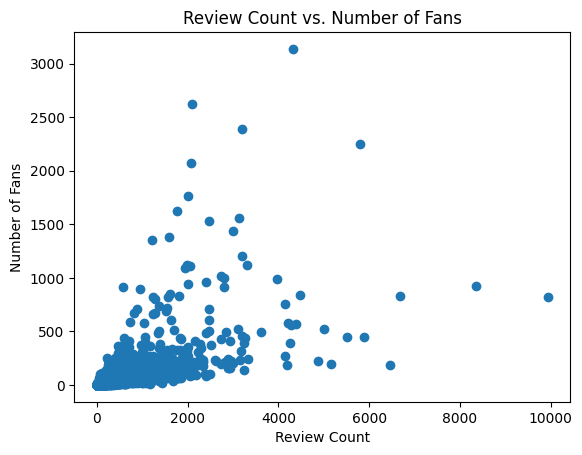

In [179]:
plt.scatter(df['review_count'], df['fans'])
plt.title('Review Count vs. Number of Fans')
plt.xlabel('Review Count')
plt.ylabel('Number of Fans')
plt.show()

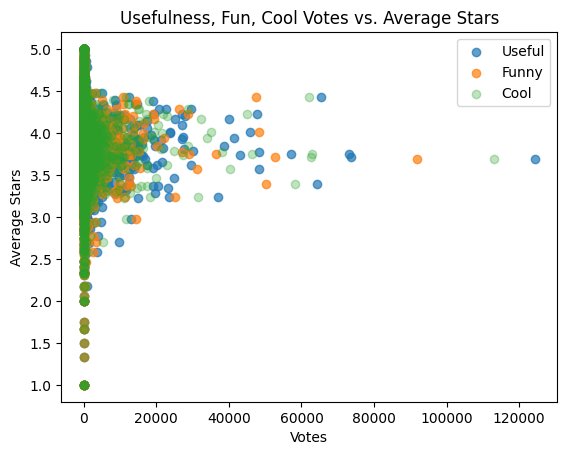

In [192]:
plt.scatter(df['useful'], df['average_stars'], label='Useful', alpha=.7)
plt.scatter(df['funny'], df['average_stars'], label='Funny', alpha=.7)
plt.scatter(df['cool'], df['average_stars'], label='Cool', alpha=.3)
plt.title('Usefulness, Fun, Cool Votes vs. Average Stars')
plt.xlabel('Votes')
plt.ylabel('Average Stars')
plt.legend()
plt.show()